# Procount

In [1]:
import ast
import collections
import os
import sys

!{sys.executable} -m pip install slurmqueen -q

from slurmqueen import ExperimentConfig
from slurmqueen import SlurmExperiment
from slurmqueen import SlurmServer
from slurmqueen.experiment import Arg
from slurmqueen.experiment import Command
from slurmqueen.slurm_experiment import SlurmInstance

HOME = os.path.expanduser('~')

class ExpError(ValueError):
    pass

def getFilePaths(nestedDirPaths, fileSuffix):
    assert isinstance(nestedDirPaths, list)
    filePaths = []
    for nestedDirPath in nestedDirPaths:
        for (dirPath, _, fileNames) in os.walk(nestedDirPath):
            for fileName in fileNames:
                if fileName.endswith(fileSuffix):
                    filePath = os.path.join(dirPath, fileName)
                    filePath = filePath.replace('\\', '/') # Windows
                    filePaths.append(filePath)
    if filePaths == []:
        pass
#         raise ExpError(f'no file with suffix {fileSuffix} in dirs {nestedDirPaths}')
    return sorted(filePaths)

def getLines(filePath): # returns non-empty stripped lines
    lines = [line.strip() for line in open(filePath)]
    return [l for l in lines if l]

In [2]:
FLOW_LG_DATA_PATH = 'data/planning/lg/flow'
HTD_LG_DATA_PATH = 'data/planning/lg/htd'
TCS_LG_DATA_PATH = 'data/planning/lg/tcs'
LG_DATA_PATHS = [FLOW_LG_DATA_PATH, HTD_LG_DATA_PATH, TCS_LG_DATA_PATH]

HTB_DATA_PATH = 'data/planning/htb'

## dmc --ps=f:
MCS_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/mcs'
IMCS_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/mcsi'
LP_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/lp'
ILP_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/lpi'
LM_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/lm'
ILM_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/lmi'
MF_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/mf'
IMF_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/mfi'
RAND_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/rand'

## dmc --ps=t:
MCS_T_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/t_mcs'
LP_T_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/t_lp'
LM_T_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/t_lm'
MF_T_FLOW_DATA_PATH = 'data/execution/dmc/lg/flow/t_mf'

# ProCount:
FLOW_MCS_DATA_PATH = 'data/solving/dpmc/lg/flow/mcs'
FLOW_LP_DATA_PATH = 'data/solving/dpmc/lg/flow/lp'
HTD_MCS_DATA_PATH = 'data/solving/dpmc/lg/htd/mcs'
HTD_LP_DATA_PATH = 'data/solving/dpmc/lg/htd/lp'
TCS_MCS_DATA_PATH = 'data/solving/dpmc/lg/tcs/mcs'
TCS_LP_DATA_PATH = 'data/solving/dpmc/lg/tcs/lp'

D4P_DATA_PATH = 'data/solving/d4p' # D4P
PROJMC_DATA_PATH = 'data/solving/projmc' # projMC
SSAT_DATA_PATH = 'data/solving/ssat' # reSSAT

SAT_DATA_PATH = 'data/solving/sat' # CryptoMiniSat

## Setting up server

In [3]:
NETID = 'vhp1'

EXP_CONFIG = ExperimentConfig(
    server=SlurmServer('nots.rice.edu', NETID, f'{HOME}/.ssh/id_rsa'),
    partition='scavenge',
    local_directory=os.getcwd(),
    remote_directory=f'/scratch/{NETID}/procount'
)

BENCHMARK_DIR_PATHS = [
    f'benchmarks/{fam}/{ext}'
    for fam in ['bird', 'waps']
    for ext in ['cnf', 'sdimacs', 'var', 'weight', 'wpcnf']
]

class ProCountInst(SlurmInstance):
    def getTable(self, stmt, suffix):
        return self.query(stmt).rename(
            columns={col: col + suffix for col in ['count', 'time']}
        )

class ProCountExp(SlurmExperiment):
    def prepare_server(self, inst): # after file copying and before job submitting
        cmds = []
        for relPath in LG_DATA_PATHS + BENCHMARK_DIR_PATHS:
            projectsPath = f'/projects/vardi/procount/exp/{relPath}'
            scratchPath = inst.remote_experiment_path(relPath)
            cmds.append(f'mkdir -p {os.path.dirname(scratchPath)}')
            cmds.append(f'ln -sf {projectsPath} {scratchPath}')
        cmd = ' && '.join(cmds)
        inst.server.execute(cmd)

    def getInst(self):
        return ProCountInst(self, EXP_CONFIG)

WORKER_CMDS = '''
#SBATCH --profile=ALL
#SBATCH --mail-type=ALL
'''
SERIOUS_CMDS = '''
#SBATCH --exclusive
#SBATCH --constraint=ivybridge
#SBATCH --mem=30G
'''
def getWorkerCmds(serious):
    return WORKER_CMDS + SERIOUS_CMDS if serious else WORKER_CMDS

In [4]:
SECS1 = 100
SECS2 = 100
SECS3 = 1000

TIME_CMD = '/usr/bin/time -f "wallclock %e"' # writes to stderr (.log file)

def timeCmd(cmd):
    return f'{TIME_CMD} {cmd}'

def timeoutCmd(secs, cmd):
    secs = int(secs * 1.1) # allows extra time (e.g., for pipe)
    return f'timeout {secs} {cmd}'

def controlCmd(secs, cmd):
    return timeCmd(timeoutCmd(secs, cmd))

FLOW_CMD = '/solvers/flow-cutter-pace17/flow_cutter_pace17 -s 1234567 -p 100'
HTD_CMD = '/solvers/htd-master/bin/htd_main -s 1234567 --opt width --iterations 0 --strategy challenge --print-progress --preprocessing full'
TCS_CMD = 'java -classpath /solvers/TCS-Meiji -Xmx25g -Xms25g -Xss1g tw.heuristic.MainDecomposer -s 1234567 -p 100'

class LgExp(ProCountExp):
    def __init__(self, dataPath, tdCmd=FLOW_CMD, secs=SECS1, serious=True):
        self.tdCmd = tdCmd

        SlurmExperiment.__init__(
            self,
            dataPath,
            controlCmd(secs, 'lg.sif'),
            self.getArgDicts(),
            setup_commands=getWorkerCmds(serious)
        )

    def getArgDicts(self):
        return [
            {'': [self.tdCmd], '<': p} for p in getFilePaths(['benchmarks'], '.wpcnf')
        ]

In [5]:
CLUSTERINGS = [3, 4, 5, 6]

RAND = 3
MCS = 4
LP = 5
LM = 6
MF = 7
VAR_ORDERS = {
    MCS: 'MCS',
    LP: 'LP',
    LM: 'LM',
    MF: 'MF'
}

HTB_HEURISTICS = len(CLUSTERINGS) * len(VAR_ORDERS)

class HtbExp(ProCountExp):
    def __init__(self, dataPath, secs=SECS1, verbosity=1, serious=True):
        self.secs = secs
        self.verbosity = verbosity

        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            setup_commands=getWorkerCmds(serious)
        )

    def getCmds(self):
        return [
            self.getCmd(p, ch, cv)
            for ch in CLUSTERINGS
            for cv in VAR_ORDERS
            for p in getFilePaths(['benchmarks'], '.wpcnf')
        ]

    def getCmd(self, wpcnfFilePath, clustering, clusterVarOrder):
        return Command(
            controlCmd(self.secs, 'htb'),
            cf=wpcnfFilePath,
            wf=5,
            ch=clustering,
            cv=clusterVarOrder,
            rs=2020,
            vl=self.verbosity
        )

In [6]:
class DmcExp(ProCountExp):
    def __init__(
        self,
        dataPath,
        planningDataPath=FLOW_LG_DATA_PATH,
        options={},
        secs=SECS2,
        serious=True
    ):
        self.planningDataPath = planningDataPath
        self.options=options

        SlurmExperiment.__init__(
            self,
            dataPath,
            controlCmd(secs, 'dmc'),
            self.getArgDicts(),
            setup_commands=getWorkerCmds(serious)
        )

    def getArgDicts(self):
        dicts = []
        for jtFile in getFilePaths([self.planningDataPath], '.out'):
            wpcnfFile = ast.literal_eval(open(jtFile).readline())['<']
            dicts.append({
                'jf': jtFile,
                'cf': wpcnfFile,
                'wf': 5,
                'ps': self.options.get('ps', 'f'),
                'jw': self.options.get('jw', SECS1),
                'pf': 0,
                'dv': self.options.get('dv', MCS),
                'dp': 1,
                'jp': 's',
                'rs': 2020,
                'vl': 1
            })
        return dicts

In [7]:
class DpmcExp(ProCountExp):
    def __init__(
        self,
        dataPath,
        tdCmd=FLOW_CMD,
        diagramVarOrder=MCS,
        verbosity=1,
        secs=SECS3,
        serious=True
    ):
        self.tdCmd=tdCmd
        self.diagramVarOrder=diagramVarOrder
        self.verbosity=verbosity
        self.secs=secs

        SlurmExperiment.__init__(
            self,
            dataPath,
            self.getCmds(),
            setup_commands=getWorkerCmds(serious)
        )

    def getCmds(self):
        return [self.getCmd(p) for p in getFilePaths(['benchmarks'], '.wpcnf')]

    def getCmd(self, wpcnfFilePath):
        return self.getLgCmd(wpcnfFilePath) | Command(
            timeoutCmd(self.secs, 'dmc'),
            jf='-',
            cf=wpcnfFilePath,
            wf=5,
            ps='f',
            dv=self.diagramVarOrder,
            dp=1,
            jp='s',
            rs=2020,
            vl=self.verbosity
        )

    def getLgCmd(self, wpcnfFilePath):
        return Command(
            timeoutCmd(self.secs, 'lg.sif'),
            Arg.positional(self.tdCmd),
            Arg.redirection('<', wpcnfFilePath)
        )

In [8]:
class LgDmcExp(ProCountExp):
    def __init__(self, dataPath, td, dv, secs=SECS3, serious=True):
        self.td = td
        self.dv = dv

        SlurmExperiment.__init__(
            self,
            dataPath,
            controlCmd(secs, 'LgDmc.sh'),
            self.getArgDicts(),
            setup_commands=getWorkerCmds(serious)
        )

    def getArgDicts(self):
        return [self.getArgDict(p) for p in getFilePaths(['benchmarks'], '.wpcnf')]

    def getArgDict(self, wpcnfFilePath):
        return {'': [wpcnfFilePath, self.td, self.dv]}

In [9]:
class D4Exp(ProCountExp):
    def __init__(self, dataPath, secs, serious):
        SlurmExperiment.__init__(
            self,
            dataPath,
            controlCmd(secs, 'd4'),
            self.getArgDicts(),
            setup_commands=getWorkerCmds(serious)
        )

    def getArgDicts(self):
        return [
            {
                '': self.getFlags() + [
                    cnfFile,
                    f'-fpv={cnfFile.replace("cnf", "var")}',
                    f'-wFile={cnfFile.replace("cnf", "weight")}'
                ]
            }
            for cnfFile in getFilePaths(['benchmarks'], '.cnf')
        ]

class D4pExp(D4Exp):
    def __init__(self, dataPath, secs=SECS3, serious=True):
        D4Exp.__init__(self, dataPath, secs, serious)

    def getFlags(self):
        return ['-mc', '-pv=NO']

class ProjmcExp(D4Exp):
    def __init__(self, dataPath, secs=SECS3, serious=True):
        D4Exp.__init__(self, dataPath, secs, serious)

    def getFlags(self):
        return ['-emc']

In [10]:
class SsatExp(ProCountExp):
    def __init__(self, dataPath, secs=SECS3, serious=True):
        SlurmExperiment.__init__(
            self,
            dataPath,
            controlCmd(secs, 'abc'),
            self.getArgDicts(),
            setup_commands=getWorkerCmds(serious)
        )

    def getArgDicts(self):
        return [
            {'': ['-c', f'ssat {file}']}
            for file in getFilePaths(['benchmarks'], '.sdimacs')
        ]

class SatExp(ProCountExp):
    def __init__(self, dataPath, secs=SECS3, serious=False):
        self.secs = secs

        SlurmExperiment.__init__(
            self,
            dataPath,
            'cryptominisat',
            self.getArgDicts(),
            setup_commands=getWorkerCmds(serious)
        )

    def getArgDicts(self):
        return [self.getArgDict(p) for p in getFilePaths(['benchmarks'], '.cnf')]

    def getArgDict(self, cnfFilePath):
        return {'': [cnfFilePath], 'maxtime': self.secs, 'verb': 1}

In [11]:
FLOW_LG_EXP = LgExp(FLOW_LG_DATA_PATH, FLOW_CMD).getInst()
HTD_LG_EXP = LgExp(HTD_LG_DATA_PATH, HTD_CMD).getInst()
TCS_LG_EXP = LgExp(TCS_LG_DATA_PATH, TCS_CMD).getInst()

HTB_EXP = HtbExp(HTB_DATA_PATH).getInst()

MCS_FLOW_EXP = DmcExp(MCS_FLOW_DATA_PATH, options={'dv': MCS}).getInst()
IMCS_FLOW_EXP = DmcExp(IMCS_FLOW_DATA_PATH, options={'dv': -MCS}).getInst()
LP_FLOW_EXP = DmcExp(LP_FLOW_DATA_PATH, options={'dv': LP}).getInst()
ILP_FLOW_EXP = DmcExp(ILP_FLOW_DATA_PATH, options={'dv': -LP}).getInst()
LM_FLOW_EXP = DmcExp(LM_FLOW_DATA_PATH, options={'dv': LM}).getInst()
ILM_FLOW_EXP = DmcExp(ILM_FLOW_DATA_PATH, options={'dv': -LM}).getInst()
MF_FLOW_EXP = DmcExp(MF_FLOW_DATA_PATH, options={'dv': MF}).getInst()
IMF_FLOW_EXP = DmcExp(IMF_FLOW_DATA_PATH, options={'dv': -MF}).getInst()
RAND_FLOW_EXP = DmcExp(RAND_FLOW_DATA_PATH, options={'dv': RAND}).getInst()

MCS_T_FLOW_EXP = DmcExp(MCS_T_FLOW_DATA_PATH, options={'dv': MCS, 'ps': 't'}).getInst()
LP_T_FLOW_EXP = DmcExp(LP_T_FLOW_DATA_PATH, options={'dv': LP, 'ps': 't'}).getInst()
LM_T_FLOW_EXP = DmcExp(LM_T_FLOW_DATA_PATH, options={'dv': LM, 'ps': 't'}).getInst()
MF_T_FLOW_EXP = DmcExp(MF_T_FLOW_DATA_PATH, options={'dv': MF, 'ps': 't'}).getInst()

FLOW_MCS_EXP = LgDmcExp(FLOW_MCS_DATA_PATH, 'flow', MCS).getInst() # DpmcExp in paper
FLOW_LP_EXP = LgDmcExp(FLOW_LP_DATA_PATH, 'flow', LP).getInst() # DpmcExp in supplement
HTD_MCS_EXP = LgDmcExp(HTD_MCS_DATA_PATH, 'htd', MCS).getInst()
HTD_LP_EXP = LgDmcExp(HTD_LP_DATA_PATH, 'htd', LP).getInst()
TCS_MCS_EXP = LgDmcExp(TCS_MCS_DATA_PATH, 'tcs', MCS).getInst()
TCS_LP_EXP = LgDmcExp(TCS_LP_DATA_PATH, 'tcs', LP).getInst()

D4P_EXP = D4pExp(D4P_DATA_PATH).getInst()
PROJMC_EXP = ProjmcExp(PROJMC_DATA_PATH).getInst()
SSAT_EXP = SsatExp(SSAT_DATA_PATH).getInst()

SAT_EXP = SatExp(SAT_DATA_PATH).getInst()

In [12]:
BENCHMARKS = len(getFilePaths(['benchmarks'], '.cnf')) # 891

WORKERS = 500 # at most 1000 workers in total at all times

def getWorkerSecs(taskSecs, workers, heuristics=1): # worker |-> many tasks (.in files)
    workerSecs = BENCHMARKS * taskSecs * heuristics / workers
    return int(workerSecs * 1.5) # allows extra time for worker, just to be safe

def getSlurmTime(secs):
    return f'0:{secs}' # mins:secs

## ints:
WORKER_SECS1LG = getWorkerSecs(SECS1, WORKERS)
WORKER_SECS1HTB = getWorkerSecs(SECS1, WORKERS, HTB_HEURISTICS)
WORKER_SECS2 = getWorkerSecs(SECS2, WORKERS)
WORKER_SECS3 = getWorkerSecs(SECS3, WORKERS)

## strings:
SLURM_TIME1LG = getSlurmTime(WORKER_SECS1LG)
SLURM_TIME1HTB = getSlurmTime(WORKER_SECS1HTB)
SLURM_TIME2 = getSlurmTime(WORKER_SECS2)
SLURM_TIME3 = getSlurmTime(WORKER_SECS3)

def checkTimes():
    print('WORKER_SECS1LG', WORKER_SECS1LG, sep='\t')
    print('WORKER_SECS1HTB', WORKER_SECS1HTB, sep='\t', end='\t')
    print(f'({HTB_HEURISTICS * BENCHMARKS} .in files)')
    print('WORKER_SECS2', WORKER_SECS2, sep='\t')
    print('WORKER_SECS3', WORKER_SECS3, sep='\t')
    print('PARTITION_SECS', 4 * 60**2, sep='\t')

# checkTimes()

## Submitting jobs to server

### Planning phase

In [13]:
# FLOW_LG_EXP.run(WORKERS, SLURM_TIME1LG)
# HTD_LG_EXP.run(WORKERS, SLURM_TIME1LG)
# TCS_LG_EXP.run(WORKERS, SLURM_TIME1LG)

# HTB_EXP.run(WORKERS, SLURM_TIME1HTB)

### Execution phase

In [14]:
# MCS_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# IMCS_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# LP_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# ILP_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# LM_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# ILM_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# MF_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# IMF_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# RAND_FLOW_EXP.run(WORKERS, SLURM_TIME2)

# MCS_T_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# LP_T_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# LM_T_FLOW_EXP.run(WORKERS, SLURM_TIME2)
# MF_T_FLOW_EXP.run(WORKERS, SLURM_TIME2)

### Solving

In [15]:
# FLOW_MCS_EXP.run(WORKERS, SLURM_TIME3)
# FLOW_LP_EXP.run(WORKERS, SLURM_TIME3)

# HTD_MCS_EXP.run(WORKERS, SLURM_TIME3)
# HTD_LP_EXP.run(WORKERS, SLURM_TIME3)

# TCS_MCS_EXP.run(WORKERS, SLURM_TIME3)
# TCS_LP_EXP.run(WORKERS, SLURM_TIME3)

# D4P_EXP.run(WORKERS, SLURM_TIME3)
# PROJMC_EXP.run(WORKERS, SLURM_TIME3)
# SSAT_EXP.run(WORKERS, SLURM_TIME3)

# SAT_EXP.run(WORKERS, SLURM_TIME3)

## Downloading data from server

### Planning phase

In [16]:
# FLOW_LG_EXP._gather()
# HTD_LG_EXP._gather()
# TCS_LG_EXP._gather()

# HTB_EXP._gather() # -bash: /usr/bin/ls: Argument list too long

### Execution phase

In [17]:
# MCS_FLOW_EXP._gather()
# IMCS_FLOW_EXP._gather()
# LP_FLOW_EXP._gather()
# ILP_FLOW_EXP._gather()
# LM_FLOW_EXP._gather()
# ILM_FLOW_EXP._gather()
# MF_FLOW_EXP._gather()
# IMF_FLOW_EXP._gather()
# RAND_FLOW_EXP._gather()

# MCS_T_FLOW_EXP._gather()
# LP_T_FLOW_EXP._gather()
# LM_T_FLOW_EXP._gather()
# MF_T_FLOW_EXP._gather()

### Solving

In [18]:
# FLOW_MCS_EXP._gather()
# FLOW_LP_EXP._gather()

# HTD_MCS_EXP._gather()
# HTD_LP_EXP._gather()

# TCS_MCS_EXP._gather()
# TCS_LP_EXP._gather()

# D4P_EXP._gather()
# PROJMC_EXP._gather()
# SSAT_EXP._gather()

# SAT_EXP._gather()

## Parsing data into local database

In [19]:
## database keys:
OUT_FILE = 'outFile'
BENCHMARK_FILE = 'benchmarkFile'
BENCHMARK = 'benchmark' # base name without extension
FAM = 'fam'
TIME = 'time'
REQUIRED_KEYS = {OUT_FILE, BENCHMARK_FILE, BENCHMARK, FAM, TIME}

def getTableTime(toolTime, wallTime):
    return toolTime if wallTime == None else wallTime

def makeDir(dirPath):
    try:
        os.makedirs(dirPath, exist_ok=True)
    except FileExistsError:
        pass

def getTime(outFilePath): # returns None if task timed out
    for line in open(outFilePath.replace('.out', '.log')):
        if line.startswith('wallclock'):
            try:
                return float(line.split()[1])
            except ValueError:
                print(
                    f'file {outFilePath} has wrong wallclock line:\n\t{line}',
                    end=''
                )

def writeOutFile(table, outFilePath):
    for key in REQUIRED_KEYS:
        if key not in table:
            raise ExpError(f'key {key} not in table {table}')
    lines = [f'{key}:{value}' for (key, value) in table.items()]
    string = '\n'.join(lines)
    with open(outFilePath, 'w') as file:
        file.write(f'{{}}\n{string}\n')

def getBenchmarkFam(benchmarkPath): # returns (benchmark, fam)
    benchmark = os.path.splitext(os.path.basename(benchmarkPath))[0]
    return (benchmark, 'bird' if 'no_w' in benchmark else 'waps')

def getNewDirPath(dirPath):
    return f'{dirPath}0'

def writeNewOutDir(outDirPath, writeNewOutFile): # must not overwrite outDirPath
    newOutDirPath = getNewDirPath(outDirPath)
    makeDir(newOutDirPath)
    for filePath in getFilePaths([outDirPath], '.out'):
        newFilePath = filePath.replace(outDirPath, newOutDirPath)
        writeNewOutFile(filePath, newFilePath)

### Planning phase

#### lg

In [20]:
def getLeafVarSets(wpcnfFilePath): # returns dict: join leaf |-> vars (1-indexing)
    clause = 0
    varSets = {}
    for line in open(wpcnfFilePath):
        words = line.split()
        if words[0] not in {'p', 'vp', 'w'}: # clause line
            clause += 1
            varSets[clause] = {abs(int(num)) for num in words[:-1]}
    return varSets

def getInternalNodeVarsSize(
    internalNodeLine,
    leafVarSets
): # returns (node, vars, size)
    (nodes, elimVars) = internalNodeLine.split('e')
    nodes = [int(n) for n in nodes.split()]
    internalVars = set()
    for child in nodes[1:]: # excluding this internal node
        internalVars.update(leafVarSets[child])
    elimVars = {int(var) for var in elimVars.split()}
    return (nodes[0], internalVars - elimVars, len(internalVars))

In [21]:
def writeNewLgOutFile(
    outFilePath,
    newOutFilePath,
    decomposer
): # must not overwrite outFilePath
    table = {OUT_FILE: outFilePath, PLANNER: 'lg', 'td': decomposer}

    timedWidths = collections.OrderedDict({None: None}) # time |-> width
    for line in open(outFilePath):
        words = line.split()
        if line.startswith('{'): # top echo line
            benchmarkPath = ast.literal_eval(line)['<']
            (benchmark, fam) = getBenchmarkFam(benchmarkPath)
            table.update(
                {BENCHMARK_FILE: benchmarkPath, BENCHMARK: benchmark, FAM: fam}
            )
            LEAF_VAR_SETS = getLeafVarSets(benchmarkPath)
            LEAF_WIDTH = max([len(varSet) for varSet in LEAF_VAR_SETS.values()])
        elif line.startswith('p jt'): # resets current join tree
            varSets = LEAF_VAR_SETS
            width = LEAF_WIDTH
        elif line.startswith('c seconds'):
            time = float(words[2])
            timedWidths[time] = width
        elif words[0] not in {'c', '='}: # internal-node line
            (node, varSet, size) = getInternalNodeVarsSize(line, varSets)
            varSets[node] = varSet
            width = max(width, size)

    tws = list(timedWidths.items())
    (time, width) = tws[-1]
    table.update({TREES: len(tws) - 1, TIME: time, WIDTH: width})
    for tree in range(1, len(tws)): # all non-None join trees
        (t, w) = tws[tree]
        table[f'{TIME}{tree}'] = t
        table[f'{WIDTH}{tree}'] = w

    writeOutFile(table, newOutFilePath)

def writeNewFlowOutFile(outFilePath, newOutFilePath):
    writeNewLgOutFile(outFilePath, newOutFilePath, 'flow')

def writeNewHtdOutFile(outFilePath, newOutFilePath):
    writeNewLgOutFile(outFilePath, newOutFilePath, 'htd')

def writeNewTcsOutFile(outFilePath, newOutFilePath):
    writeNewLgOutFile(outFilePath, newOutFilePath, 'tcs')

In [22]:
# writeNewOutDir(FLOW_LG_DATA_PATH, writeNewFlowOutFile) # slow
# writeNewOutDir(HTD_LG_DATA_PATH, writeNewHtdOutFile) # slow
# writeNewOutDir(TCS_LG_DATA_PATH, writeNewTcsOutFile) # slow

FLOW0 = LgExp(getNewDirPath(FLOW_LG_DATA_PATH)).getInst()
HTD0 = LgExp(getNewDirPath(HTD_LG_DATA_PATH)).getInst()
TCS0 = LgExp(getNewDirPath(TCS_LG_DATA_PATH)).getInst()

In [23]:
timedWidths = ','.join([f'time{i},width{i}' for i in range(1, 6)])

FLOW_TABLE = FLOW0.query(f'''
select benchmark,trees,time,width,{timedWidths} from data
where width1 > 30 and width2 > 0
order by width1,time
''')

FLOW_TABLE

,benchmark,trees,time,width,time1,width1,time2,width2,time3,width3,time4,width4,time5,width5
0,registerlesSwap.sk_3_10.no_w,2,0.163678,25.0,0.034877,31.0,0.163678,25.0,NaN,NaN,NaN,NaN,NaN,NaN
1,blasted_case54.no_w,2,0.178187,29.0,0.023337,32.0,0.178187,29.0,NaN,NaN,NaN,NaN,NaN,NaN
2,blasted_case124.no_w,2,0.481052,32.0,0.014460,33.0,0.481052,32.0,NaN,NaN,NaN,NaN,NaN,NaN
3,blasted_case55.no_w,2,0.077132,31.0,0.016397,35.0,0.077132,31.0,NaN,NaN,NaN,NaN,NaN,NaN
4,s832a_15_7.no_w,2,0.222571,34.0,0.042243,35.0,0.222571,34.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,s1423a_15_7,2,0.560692,93.0,0.048684,93.0,0.560692,93.0,NaN,NaN,NaN,NaN,NaN,NaN
140,s1423a_15_7.no_w,2,0.609546,93.0,0.081609,93.0,0.609546,93.0,NaN,NaN,NaN,NaN,NaN,NaN
141,blasted_case_2_ptb_1.no_w,3,83.674800,93.0,0.104926,95.0,83.662100,94.0,83.6748,93.0,NaN,NaN,NaN,NaN
142,ConcreteActivityService.sk_13_28.no_w,2,4.723130,85.0,0.294218,97.0,4.723130,85.0,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
timedWidths = ','.join([f'time{i},width{i}' for i in range(1, 10)])

HTD_TABLE = HTD0.query(f'''
select benchmark,trees,time,width,{timedWidths} from data
where time <= 100 and width1 is not null
order by width,time
''')

HTD_TABLE

,benchmark,trees,time,width,time1,width1,time2,width2,time3,width3,...,time5,width5,time6,width6,time7,width7,time8,width8,time9,width9
0,tutorial1.sk_1_1.no_w,2,0.024886,1.0,0.024387,1.0,0.024886,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tableBasedAddition.sk_240_1024.no_w,1,0.034731,1.0,0.034731,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,blasted_case206.no_w,2,0.020606,7.0,0.020442,14.0,0.020606,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,blasted_case200.no_w,2,0.023950,7.0,0.023787,14.0,0.023950,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,s27_3_2,2,0.019342,8.0,0.019165,20.0,0.019342,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,blasted_case_0_b14_1.no_w,1,0.049222,98.0,0.049222,98.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
358,81.sk_5_51.no_w,1,1.236850,98.0,1.236850,98.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
359,LoginService.sk_20_34.no_w,2,9.758430,98.0,4.879360,100.0,9.758430,98.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
360,blasted_case130.no_w,1,0.053286,99.0,0.053286,99.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
timedWidths = ','.join([f'time{i},width{i}' for i in range(1, 20)])

TCS_TABLE = TCS0.query(f'''
select benchmark,trees,time,width,{timedWidths} from data
where time <= 100 and width1 is not null
order by width,time
''')

TCS_TABLE

,benchmark,trees,time,width,time1,width1,time2,width2,time3,width3,...,time15,width15,time16,width16,time17,width17,time18,width18,time19,width19
0,tutorial1.sk_1_1.no_w,1,0.361924,1.0,0.361924,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tableBasedAddition.sk_240_1024.no_w,1,0.424256,1.0,0.424256,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,blasted_case206.no_w,2,0.388145,7.0,0.378406,13.0,0.388145,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,blasted_case200.no_w,2,0.389369,7.0,0.380464,13.0,0.389369,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,blasted_case60.no_w,2,0.367497,8.0,0.358477,13.0,0.367497,8.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,s1423a_15_7.no_w,3,23.794600,90.0,6.251830,92.0,7.181470,91.0,23.7946,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316,s1423a_3_2,2,24.653300,90.0,4.711020,92.0,24.653300,90.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,s1423a_7_4.no_w,3,24.912800,90.0,5.204360,92.0,6.269800,91.0,24.9128,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318,blasted_case_0_b14_1.no_w,1,12.666900,98.0,12.666900,98.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### htb

In [26]:
def writeNewHtbOutFile(outFilePath, newOutFilePath): # must not overwrite outFilePath
    table = {OUT_FILE: outFilePath, PLANNER: 'htb'}

    width = None
    time = None
    try:
        for line in open(outFilePath):
            words = line.split()
            if line.startswith('{'): # top echo line
                argDict = ast.literal_eval(line)
                benchmarkPath = argDict['cf']
                (benchmark, fam) = getBenchmarkFam(benchmarkPath)
                clustering = argDict['ch']
                table.update({
                    BENCHMARK_FILE: benchmarkPath,
                    BENCHMARK: benchmark,
                    FAM: fam,
                    'rank': 'BE' if clustering in {3, 4} else 'BM',
                    'choice': 'List' if clustering in {3, 5} else 'Tree',
                    'cv': VAR_ORDERS[argDict['cv']]
                })
            elif line.startswith('c joinTreeWidth'):
                width = int(words[2])
            elif line.startswith('c seconds'):
                time = float(words[2])
    except UnicodeDecodeError:
        print(f'WARNING: unable to decode file {outFilePath}')

    table.update({TIME: time, WIDTH: width})

    writeOutFile(table, newOutFilePath)

In [27]:
# writeNewOutDir(HTB_DATA_PATH, writeNewHtbOutFile)

HTB0 = HtbExp(getNewDirPath(HTB_DATA_PATH)).getInst()

HTB_TABLE = HTB0.query('''
select outFile,benchmark,cv,rank,choice,width,time from data
where width is not null and time <= 100
order by width,time
''')

HTB_TABLE

,outFile,benchmark,cv,rank,choice,width,time
0,data/planning/htb/05252.out,tutorial1.sk_1_1.no_w,LP,BE,Tree,1.0,0.022
1,data/planning/htb/01688.out,tutorial1.sk_1_1.no_w,LP,BE,List,1.0,0.023
2,data/planning/htb/08816.out,tutorial1.sk_1_1.no_w,LP,BM,List,1.0,0.023
3,data/planning/htb/11489.out,tutorial1.sk_1_1.no_w,MCS,BM,Tree,1.0,0.023
4,data/planning/htb/12380.out,tutorial1.sk_1_1.no_w,LP,BM,Tree,1.0,0.023
...,...,...,...,...,...,...,...
5796,data/planning/htb/03619.out,08B-1.no_w,MCS,BE,Tree,9078.0,71.137
5797,data/planning/htb/03609.out,07B-1.no_w,MCS,BE,Tree,9078.0,74.577
5798,data/planning/htb/00055.out,08B-1.no_w,MCS,BE,List,9078.0,74.902
5799,data/planning/htb/00045.out,07B-1.no_w,MCS,BE,List,9078.0,76.454


### Execution phase

#### dmc

In [28]:
PS = 'ps' # planning strategy
DV = 'dv' # diagram var order
DP = 'dp' # diagram package
JP = 'jp' # join priority
DMC_OPTIONS = [PS, DV, DP, JP]

def writeNewDmcOutFile(outFilePath, newOutFilePath): # must not overwrite outFilePath
    table = {OUT_FILE: outFilePath, 'executor': 'dmc'}

    lines = getLines(outFilePath)

    argDict = ast.literal_eval(lines[0])

    for (k, v) in argDict.items():
        if k == '': # LgDmc.sh
            (cf, td, dv) = v
            table['td'] = td
            table['dv'] = dv
        elif k == 'cf':
            cf = v
        elif k in DMC_OPTIONS:
            table[k] = v

    (benchmark, fam) = getBenchmarkFam(cf)
    table.update({BENCHMARK_FILE: cf, BENCHMARK: benchmark, FAM: fam})

    count = None
    toolTime = None
    for line in lines:
        words = line.split()
        if line.startswith('s wmc'):
            count = float(words[2])
        elif line.startswith('c seconds'):
            toolTime = float(words[2])
    table['count'] = count
    table['toolTime'] = toolTime
    wallTime = getTime(outFilePath)
    table['wallTIme'] = wallTime
    table[TIME] = getTableTime(toolTime, wallTime)

    writeOutFile(table, newOutFilePath)

In [29]:
# writeNewOutDir(MCS_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(IMCS_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(LP_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(ILP_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(LM_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(ILM_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(MF_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(IMF_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(RAND_FLOW_DATA_PATH, writeNewDmcOutFile)

# writeNewOutDir(MCS_T_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(LP_T_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(LM_T_FLOW_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(MF_T_FLOW_DATA_PATH, writeNewDmcOutFile)

##### dmc --ps=f

In [30]:
MCS_FLOW0 = DmcExp(getNewDirPath(MCS_FLOW_DATA_PATH)).getInst()

MCS_FLOW_TABLE = MCS_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

MCS_FLOW_TABLE

,benchmark,count,time
0,blasted_squaring22.no_w,2.318080e-12,7.195
1,blasted_squaring21.no_w,3.676190e-12,4.852
2,blasted_squaring24.no_w,4.572740e-12,7.379
3,blasted_squaring27.no_w,4.582850e-12,10.576
4,blasted_squaring20.no_w,5.521710e-12,18.135
...,...,...,...
259,s1423a_7_4,7.534170e-01,27.693
260,s27_new_7_4,7.856080e-01,0.025
261,s713_3_2,8.029210e-01,0.075
262,s832a_15_7,8.206490e-01,0.103


In [31]:
IMCS_FLOW0 = DmcExp(getNewDirPath(IMCS_FLOW_DATA_PATH)).getInst()

IMCS_FLOW_TABLE = IMCS_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

IMCS_FLOW_TABLE

,benchmark,count,time
0,blasted_squaring27.no_w,4.584400e-12,65.909
1,blasted_case143.no_w,2.874990e-07,2.916
2,blasted_case132.no_w,8.163120e-07,0.347
3,blasted_case135.no_w,1.537100e-06,0.508
4,s820a_3_2,1.805310e-06,0.057
...,...,...,...
244,s838_3_2,7.254650e-01,0.088
245,s27_new_7_4,7.856080e-01,0.003
246,s713_3_2,8.029210e-01,0.066
247,s832a_15_7,8.206490e-01,0.083


In [32]:
LP_FLOW0 = DmcExp(getNewDirPath(LP_FLOW_DATA_PATH)).getInst()

LP_FLOW_TABLE = LP_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

LP_FLOW_TABLE

,benchmark,count,time
0,blasted_squaring4.no_w,6.382280e-12,38.381
1,blasted_squaring2.no_w,9.294120e-12,28.112
2,blasted_squaring6.no_w,1.590530e-11,25.448
3,blasted_squaring1.no_w,1.810920e-11,23.718
4,blasted_squaring5.no_w,1.814800e-11,26.431
...,...,...,...
258,s1423a_7_4,7.534170e-01,40.591
259,s27_new_7_4,7.856080e-01,0.003
260,s713_3_2,8.029210e-01,0.072
261,s832a_15_7,8.206490e-01,0.093


In [33]:
ILP_FLOW0 = DmcExp(getNewDirPath(ILP_FLOW_DATA_PATH)).getInst()

ILP_FLOW_TABLE = ILP_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

ILP_FLOW_TABLE

,benchmark,count,time
0,blasted_case143.no_w,2.874990e-07,5.031
1,blasted_case132.no_w,8.163120e-07,29.382
2,blasted_case135.no_w,1.537100e-06,26.801
3,s820a_3_2,1.805310e-06,0.069
4,blasted_squaring51.no_w,2.652770e-06,19.968
...,...,...,...
240,s838_3_2,7.254650e-01,0.154
241,s27_new_7_4,7.856080e-01,0.004
242,s713_3_2,8.029210e-01,0.084
243,s832a_15_7,8.206490e-01,0.105


In [34]:
LM_FLOW0 = DmcExp(getNewDirPath(LM_FLOW_DATA_PATH)).getInst()

LM_FLOW_TABLE = LM_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

LM_FLOW_TABLE

,benchmark,count,time
0,blasted_squaring22.no_w,2.324020e-12,32.742
1,blasted_squaring21.no_w,3.283530e-12,32.780
2,blasted_squaring23.no_w,4.305380e-12,44.487
3,blasted_squaring24.no_w,4.564610e-12,32.075
4,blasted_squaring27.no_w,4.587850e-12,46.235
...,...,...,...
261,s838_3_2,7.254650e-01,6.264
262,s27_new_7_4,7.856080e-01,0.006
263,s713_3_2,8.029210e-01,3.826
264,s832a_15_7,8.206490e-01,9.661


In [35]:
ILM_FLOW0 = DmcExp(getNewDirPath(ILM_FLOW_DATA_PATH)).getInst()

ILM_FLOW_TABLE = ILM_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

ILM_FLOW_TABLE

,benchmark,count,time
0,blasted_squaring22.no_w,2.322910e-12,29.037
1,blasted_squaring21.no_w,3.639180e-12,25.906
2,blasted_squaring23.no_w,4.219860e-12,33.224
3,blasted_squaring27.no_w,4.580050e-12,59.262
4,blasted_squaring24.no_w,4.843070e-12,28.728
...,...,...,...
260,s1423a_7_4,7.534170e-01,84.037
261,s27_new_7_4,7.856080e-01,0.005
262,s713_3_2,8.029210e-01,3.828
263,s832a_15_7,8.206490e-01,9.798


In [36]:
MF_FLOW0 = DmcExp(getNewDirPath(MF_FLOW_DATA_PATH)).getInst()

MF_FLOW_TABLE = MF_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

MF_FLOW_TABLE

,benchmark,count,time
0,blasted_case143.no_w,2.874990e-07,16.934
1,blasted_case132.no_w,8.163120e-07,0.079
2,blasted_case135.no_w,1.537100e-06,0.083
3,s820a_3_2,1.805310e-06,0.958
4,blasted_squaring51.no_w,2.652770e-06,16.403
...,...,...,...
240,s838_3_2,7.254650e-01,0.381
241,s27_new_7_4,7.856080e-01,0.003
242,s713_3_2,8.029210e-01,0.164
243,s832a_15_7,8.206490e-01,1.068


In [37]:
IMF_FLOW0 = DmcExp(getNewDirPath(IMF_FLOW_DATA_PATH)).getInst()

IMF_FLOW_TABLE = IMF_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

IMF_FLOW_TABLE

,benchmark,count,time
0,blasted_case143.no_w,2.874990e-07,5.518
1,blasted_case132.no_w,8.163120e-07,0.084
2,blasted_case135.no_w,1.537100e-06,0.079
3,s820a_3_2,1.805310e-06,0.734
4,blasted_squaring51.no_w,2.652770e-06,4.094
...,...,...,...
243,s1423a_7_4,7.534170e-01,42.033
244,s27_new_7_4,7.856080e-01,0.003
245,s713_3_2,8.029210e-01,0.102
246,s832a_15_7,8.206490e-01,1.068


In [38]:
RAND_FLOW0 = DmcExp(getNewDirPath(RAND_FLOW_DATA_PATH)).getInst()

RAND_FLOW_TABLE = RAND_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

RAND_FLOW_TABLE

,benchmark,count,time
0,blasted_squaring27.no_w,4.703430e-12,30.381
1,blasted_case143.no_w,2.874990e-07,9.394
2,blasted_case132.no_w,8.163120e-07,0.280
3,blasted_case135.no_w,1.537100e-06,0.329
4,s820a_3_2,1.805310e-06,0.055
...,...,...,...
250,s838_3_2,7.254650e-01,0.054
251,s27_new_7_4,7.856080e-01,0.003
252,s713_3_2,8.029210e-01,0.067
253,s832a_15_7,8.206490e-01,0.091


##### dmc --ps=t

In [39]:
MCS_T_FLOW0 = DmcExp(getNewDirPath(MCS_T_FLOW_DATA_PATH)).getInst()

MCS_T_FLOW_TABLE = MCS_T_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

MCS_T_FLOW_TABLE

,benchmark,count,time
0,blasted_squaring22.no_w,2.318150e-12,5.776
1,blasted_squaring21.no_w,3.676190e-12,4.835
2,blasted_squaring24.no_w,4.552120e-12,5.601
3,blasted_squaring27.no_w,4.576080e-12,7.625
4,blasted_squaring20.no_w,5.567780e-12,5.703
...,...,...,...
260,s1423a_7_4,7.534170e-01,27.889
261,s27_new_7_4,7.856080e-01,0.026
262,s713_3_2,8.029210e-01,0.073
263,s832a_15_7,8.206490e-01,0.090


In [40]:
LP_T_FLOW0 = DmcExp(getNewDirPath(LP_T_FLOW_DATA_PATH)).getInst()

LP_T_FLOW_TABLE = LP_T_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

LP_T_FLOW_TABLE

,benchmark,count,time
0,blasted_squaring4.no_w,6.361200e-12,22.561
1,blasted_squaring2.no_w,9.233300e-12,20.625
2,blasted_squaring6.no_w,1.580580e-11,21.329
3,blasted_squaring1.no_w,1.809350e-11,37.919
4,blasted_squaring5.no_w,1.825340e-11,20.551
...,...,...,...
257,s1423a_7_4,7.534170e-01,42.124
258,s27_new_7_4,7.856080e-01,0.003
259,s713_3_2,8.029210e-01,0.067
260,s832a_15_7,8.206490e-01,0.100


In [41]:
LM_T_FLOW0 = DmcExp(getNewDirPath(LM_T_FLOW_DATA_PATH)).getInst()

LM_T_FLOW_TABLE = LM_T_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

LM_T_FLOW_TABLE

,benchmark,count,time
0,blasted_squaring22.no_w,2.324020e-12,37.861
1,blasted_squaring21.no_w,3.283530e-12,32.987
2,blasted_squaring23.no_w,4.305380e-12,41.973
3,blasted_squaring24.no_w,4.564610e-12,37.456
4,blasted_squaring27.no_w,4.587850e-12,42.003
...,...,...,...
263,s838_3_2,7.254650e-01,6.275
264,s27_new_7_4,7.856080e-01,0.175
265,s713_3_2,8.029210e-01,3.844
266,s832a_15_7,8.206490e-01,9.654


In [42]:
MF_T_FLOW0 = DmcExp(getNewDirPath(MF_T_FLOW_DATA_PATH)).getInst()

MF_T_FLOW_TABLE = MF_T_FLOW0.query('''
select benchmark,count,time from data where time <= 100 and count > 0
order by count
''')

MF_T_FLOW_TABLE

,benchmark,count,time
0,blasted_case143.no_w,2.874990e-07,15.137
1,blasted_case132.no_w,8.163120e-07,0.083
2,blasted_case135.no_w,1.537100e-06,0.090
3,s820a_3_2,1.805310e-06,0.771
4,blasted_squaring51.no_w,2.652770e-06,13.528
...,...,...,...
240,s838_3_2,7.254650e-01,0.375
241,s27_new_7_4,7.856080e-01,0.003
242,s713_3_2,8.029210e-01,0.114
243,s832a_15_7,8.206490e-01,1.044


### Solving

#### dpmc

In [43]:
# writeNewOutDir(FLOW_MCS_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(FLOW_LP_DATA_PATH, writeNewDmcOutFile)

# writeNewOutDir(HTD_MCS_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(HTD_LP_DATA_PATH, writeNewDmcOutFile)

# writeNewOutDir(TCS_MCS_DATA_PATH, writeNewDmcOutFile)
# writeNewOutDir(TCS_LP_DATA_PATH, writeNewDmcOutFile)

In [44]:
FLOW_MCS0 = DpmcExp(getNewDirPath(FLOW_MCS_DATA_PATH)).getInst()

FLOW_MCS_TABLE = FLOW_MCS0.query('''
select benchmark,count,time,toolTime,wallTime from data
where time <= 1000 and count > 0
order by count
''')

FLOW_MCS_TABLE

,benchmark,count,time,toolTime,wallTime
0,blasted_squaring22.no_w,2.318080e-12,8.023,8.023,None
1,blasted_squaring21.no_w,3.676190e-12,5.220,5.220,None
2,blasted_squaring23.no_w,4.180910e-12,182.826,182.826,None
3,blasted_squaring24.no_w,4.572740e-12,7.499,7.499,None
4,blasted_squaring27.no_w,4.582850e-12,10.581,10.581,None
...,...,...,...,...,...
278,s1423a_7_4,7.534170e-01,28.028,28.028,None
279,s27_new_7_4,7.856080e-01,0.102,0.102,None
280,s713_3_2,8.029210e-01,0.167,0.167,None
281,s832a_15_7,8.206490e-01,0.213,0.213,None


In [45]:
FLOW_LP0 = DpmcExp(getNewDirPath(FLOW_LP_DATA_PATH)).getInst()

FLOW_LP_TABLE = FLOW_LP0.query('''
select benchmark,count,time from data
where time <= 1000 and count > 0
order by count
''')

FLOW_LP_TABLE

,benchmark,count,time
0,blasted_squaring22.no_w,2.334420e-12,380.733
1,blasted_squaring21.no_w,3.674970e-12,375.118
2,blasted_squaring27.no_w,4.582850e-12,837.172
3,blasted_squaring24.no_w,4.646960e-12,374.483
4,blasted_squaring20.no_w,5.553810e-12,620.405
...,...,...,...
279,s1423a_7_4,7.534170e-01,42.044
280,s27_new_7_4,7.856080e-01,0.102
281,s713_3_2,8.029210e-01,0.182
282,s832a_15_7,8.206490e-01,0.224


In [46]:
HTD_MCS0 = DpmcExp(getNewDirPath(HTD_MCS_DATA_PATH)).getInst()

HTD_MCS_TABLE = HTD_MCS0.query('''
select benchmark,count,time,toolTime,wallTime from data
where time <= 1000 and count > 0
order by count
''')

HTD_MCS_TABLE

,benchmark,count,time,toolTime,wallTime
0,blasted_squaring22.no_w,2.334010e-12,3.770,3.770,3.85
1,blasted_squaring21.no_w,3.769320e-12,5.163,5.163,5.25
2,blasted_squaring23.no_w,4.273800e-12,7.354,7.354,7.44
3,blasted_squaring27.no_w,4.576080e-12,5.617,5.617,5.70
4,blasted_squaring24.no_w,4.703460e-12,3.618,3.618,3.70
...,...,...,...,...,...
278,s1423a_7_4,7.534170e-01,27.170,27.170,27.28
279,s27_new_7_4,7.856080e-01,0.219,0.219,0.30
280,s713_3_2,8.029210e-01,0.194,0.194,0.26
281,s832a_15_7,8.206490e-01,0.232,0.232,0.30


In [47]:
HTD_LP0 = DpmcExp(getNewDirPath(HTD_LP_DATA_PATH)).getInst()

HTD_LP_TABLE = HTD_LP0.query('''
select benchmark,count,time,toolTime,wallTime from data
where time <= 1000 and count > 0
order by count
''')

HTD_LP_TABLE

,benchmark,count,time,toolTime,wallTime
0,blasted_squaring22.no_w,2.365020e-12,186.627,186.627,186.80
1,blasted_squaring21.no_w,3.674970e-12,184.965,184.965,185.15
2,blasted_squaring23.no_w,4.210820e-12,294.466,294.466,294.69
3,blasted_squaring27.no_w,4.583910e-12,131.145,131.145,131.27
4,blasted_squaring24.no_w,4.653210e-12,189.541,189.541,189.70
...,...,...,...,...,...
279,s1423a_7_4,7.534170e-01,41.354,41.354,41.47
280,s27_new_7_4,7.856080e-01,0.131,0.131,0.20
281,s713_3_2,8.029210e-01,0.199,0.199,0.27
282,s832a_15_7,8.206490e-01,0.237,0.237,0.30


In [48]:
TCS_MCS0 = DpmcExp(getNewDirPath(TCS_MCS_DATA_PATH)).getInst()

TCS_MCS_TABLE = TCS_MCS0.query('''
select benchmark,count,time,toolTime,wallTime from data
where time <= 1000 and count > 0
order by count
''')

TCS_MCS_TABLE

,benchmark,count,time,toolTime,wallTime
0,blasted_squaring22.no_w,2.271710e-12,12.725,12.725,12.85
1,blasted_squaring21.no_w,3.696740e-12,13.297,13.297,13.38
2,blasted_squaring23.no_w,4.231430e-12,14.432,14.432,14.53
3,blasted_squaring27.no_w,4.582850e-12,18.316,18.316,18.40
4,blasted_squaring24.no_w,4.662310e-12,13.038,13.038,13.12
...,...,...,...,...,...
265,s1423a_7_4,7.534170e-01,32.163,32.163,32.27
266,s27_new_7_4,7.856080e-01,0.513,0.513,0.58
267,s713_3_2,8.029210e-01,1.403,1.403,1.48
268,s832a_15_7,8.206490e-01,2.705,2.705,2.77


In [49]:
TCS_LP0 = DpmcExp(getNewDirPath(TCS_LP_DATA_PATH)).getInst()

TCS_LP_TABLE = TCS_LP0.query('''
select benchmark,count,time,toolTime,wallTime from data
where time <= 1000 and count > 0
order by count
''')

TCS_LP_TABLE

,benchmark,count,time,toolTime,wallTime
0,blasted_squaring22.no_w,2.386580e-12,90.735,90.735,90.85
1,blasted_squaring21.no_w,3.643760e-12,89.614,89.614,89.72
2,blasted_squaring23.no_w,4.183050e-12,94.107,94.107,94.22
3,blasted_squaring27.no_w,4.581150e-12,141.438,141.438,141.57
4,blasted_squaring24.no_w,4.622990e-12,89.940,89.940,90.06
...,...,...,...,...,...
284,s1423a_7_4,7.534170e-01,46.672,46.672,46.77
285,s27_new_7_4,7.856080e-01,0.485,0.485,0.55
286,s713_3_2,8.029210e-01,1.384,1.384,1.45
287,s832a_15_7,8.206490e-01,2.748,2.748,2.81


#### d4p

In [50]:
def writeNewD4OutFile(
    outFilePath,
    newOutFilePath,
    projmc
): # must not overwrite outFilePath
    lines = getLines(outFilePath)

    benchmarkPath = ast.literal_eval(lines[0])[''][1 if projmc else 2]
    (benchmark, fam) = getBenchmarkFam(benchmarkPath)
    table = {
        OUT_FILE: outFilePath,
        BENCHMARK_FILE: benchmarkPath,
        BENCHMARK: benchmark,
        FAM: fam,
        'solver': 'projmc' if projmc else 'd4p'
    }

    count = None
    toolTime = None
    for line in lines:
        words = line.split()
        if line.startswith('c Final time:'):
            toolTime = float(words[3])
        elif line.startswith('s '):
            count = float(words[1])
    table['count'] = count
    table['toolTime'] = toolTime
    wallTime = getTime(outFilePath)
    table['wallTIme'] = wallTime
    table[TIME] = getTableTime(toolTime, wallTime)

    writeOutFile(table, newOutFilePath)

def writeNewD4pOutFile(outFilePath, newOutFilePath):
    writeNewD4OutFile(outFilePath, newOutFilePath, projmc=False)

def writeNewProjmcOutFile(outFilePath, newOutFilePath):
    writeNewD4OutFile(outFilePath, newOutFilePath, projmc=True)

In [51]:
# writeNewOutDir(D4P_DATA_PATH, writeNewD4pOutFile)

D4P0 = D4pExp(getNewDirPath(D4P_DATA_PATH)).getInst()

D4P_TABLE = D4P0.query('''
select outFile,benchmark,count,time,toolTime,wallTime from data
where time <= 1000 and count > 0
order by count
''') # 42 unsat benchmarks without toolTime and 74 underflows with toolTime

D4P_TABLE

,outFile,benchmark,count,time,toolTime,wallTime
0,data/solving/d4p/176.out,LoginService2.sk_23_36.no_w,0.000001,9.005933,9.005933,9.11
1,data/solving/d4p/183.out,UserServiceImpl.sk_8_32.no_w,0.000001,0.122177,0.122177,0.16
2,data/solving/d4p/234.out,blasted_case132.no_w,0.000001,16.368550,16.368550,16.47
3,data/solving/d4p/441.out,doublyLinkedList.sk_8_37.no_w,0.000001,1.915531,1.915531,1.99
4,data/solving/d4p/688.out,polynomial.sk_7_25.no_w,0.000001,0.003428,0.003428,0.05
...,...,...,...,...,...,...
340,data/solving/d4p/524.out,leader_sync3_32.pm_4steps_7int_5fract_elected_...,0.998916,31.278531,31.278531,31.45
341,data/solving/d4p/526.out,leader_sync3_64.pm_4steps_7int_6fract_elected_...,0.999740,729.959598,729.959598,730.20
342,data/solving/d4p/527.out,leader_sync3_64.pm_4steps_7int_6fract_elected_...,0.999777,728.827712,728.827712,729.14
343,data/solving/d4p/511.out,herman3.pm_20steps_6int_1fract_stable_over.no_w,1.000000,0.257715,0.257715,0.34


#### projmc

In [52]:
# writeNewOutDir(PROJMC_DATA_PATH, writeNewProjmcOutFile)

PROJMC0 = ProjmcExp(getNewDirPath(PROJMC_DATA_PATH)).getInst()

PROJMC_TABLE = PROJMC0.query('''
select benchmark,count,time,toolTime,wallTime from data
where time <= 1000 and count > 0
order by count
''')

PROJMC_TABLE

,benchmark,count,time,toolTime,wallTime
0,LoginService2.sk_23_36.no_w,0.000001,44.566035,44.566035,44.78
1,UserServiceImpl.sk_8_32.no_w,0.000001,0.277213,0.277213,0.33
2,blasted_case132.no_w,0.000001,3.320860,3.320860,3.47
3,doublyLinkedList.sk_8_37.no_w,0.000001,2.575501,2.575501,2.98
4,polynomial.sk_7_25.no_w,0.000001,0.021690,0.021690,0.07
...,...,...,...,...,...
270,s27_new_7_4,0.785608,0.015110,0.015110,0.06
271,s832a_15_7,0.820649,0.110260,0.110260,0.15
272,s382_15_7,0.892136,2.635629,2.635629,2.73
273,leader_sync3_8.pm_4steps_7int_3fract_elected_o...,0.983872,349.960543,349.960543,350.05


#### ssat

In [53]:
def writeNewSsatOutFile(outFilePath, newOutFilePath): # must not overwrite outFilePath
    lines = getLines(outFilePath)

    benchmarkPath = ast.literal_eval(lines[0])[''][1].split()[1]
    (benchmark, fam) = getBenchmarkFam(benchmarkPath)
    table = {
        OUT_FILE: outFilePath,
        BENCHMARK_FILE: benchmarkPath,
        BENCHMARK: benchmark,
        FAM: fam,
        'solver': 'ssat'
    }

    toolTime = None
    count = None
    for line in lines:
        words = line.split()
        if line == '[INFO] Exactly solve the instance: upper bound is tight':
            pass
        elif line.startswith('> Upper bound ='):
            count = float(words[4])
        elif line.startswith('> Time        ='):
            toolTime = float(words[3])
    table['count'] = count
    table['toolTime'] = toolTime
    wallTime = getTime(outFilePath)
    table['wallTIme'] = wallTime
    table[TIME] = getTableTime(toolTime, wallTime)

    writeOutFile(table, newOutFilePath)

In [54]:
# writeNewOutDir(SSAT_DATA_PATH, writeNewSsatOutFile)

SSAT0 = SsatExp(getNewDirPath(SSAT_DATA_PATH)).getInst()

SSAT_TABLE = SSAT0.query('''
select outFile,count,time,toolTime,wallTime from data
where time <= 1000 and count > 0
order by count
''')

SSAT_TABLE

,outFile,count,time,toolTime,wallTime
0,data/solving/ssat/014.out,5.960464e-08,0.01,0.01,0.35
1,data/solving/ssat/688.out,5.960464e-07,0.01,0.01,0.11
2,data/solving/ssat/441.out,8.344650e-07,135.85,135.85,135.99
3,data/solving/ssat/183.out,1.311302e-06,3.02,3.02,3.14
4,data/solving/ssat/176.out,1.430511e-06,296.62,296.62,296.91
...,...,...,...,...,...
149,data/solving/ssat/718.out,6.167832e-01,1.26,1.26,1.36
150,data/solving/ssat/823.out,6.445653e-01,0.01,0.01,0.10
151,data/solving/ssat/523.out,7.200000e-01,3.37,3.37,3.49
152,data/solving/ssat/522.out,7.600000e-01,3.24,3.24,3.39


#### sat

In [55]:
def writeNewSatOutFile(outFilePath, newOutFilePath): # must not overwrite outFilePath
    lines = getLines(outFilePath)

    benchmarkPath = ast.literal_eval(lines[0])[''][0]
    (benchmark, fam) = getBenchmarkFam(benchmarkPath)
    table = {
        OUT_FILE: outFilePath,
        BENCHMARK_FILE: benchmarkPath,
        BENCHMARK: benchmark,
        FAM: fam,
        'solver': 'sat'
    }

    count = None
    for line in lines:
        words = line.split()
        if line.startswith('s '):
            count = 1 if words[1] == 'SATISFIABLE' else 0
            break
    table['count'] = count
    table[TIME] = 0

    writeOutFile(table, newOutFilePath)

In [56]:
# writeNewOutDir(SAT_DATA_PATH, writeNewSatOutFile)

SAT0 = SatExp(getNewDirPath(SAT_DATA_PATH)).getInst()

SATS = SAT0.query('''
select benchmark from data
where count != 0
''')

SATS # 849

,benchmark
0,01A-1.no_w
1,01B-1.no_w
2,01B-2.no_w
3,01B-3.no_w
4,01B-4.no_w
...,...
844,s9234a_3_2
845,s9234a_7_4
846,s953a_15_7
847,s953a_3_2


## Analyzing data

In [57]:
SAT_TABLE = SAT0.query('select benchmark from data where count != 0')
STMT0 = 'select benchmark,count,time from data '
SAT_TABLE = SAT_TABLE.merge(FLOW_MCS0.getTable(
    STMT0
#     + 'where time <= 1000 and count = 0' # 1 underflow
    , 'Dpmc'
))
SAT_TABLE = SAT_TABLE.merge(D4P0.getTable(
    STMT0
#     + 'where time <= 1000 and count = 0' # 74 underflows
    , 'D4p'
))
SAT_TABLE = SAT_TABLE.merge(PROJMC0.getTable(
    STMT0
#     + 'where time <= 1000 and count = 0' # 64 underflows
    , 'Projmc'
))
SAT_TABLE = SAT_TABLE.merge(SSAT0.getTable(
    STMT0
#     + 'where time <= 1000 and count = 0' # 56 underflows
    , 'Ssat'
))

SAT_TABLE

,benchmark,countDpmc,timeDpmc,countD4p,timeD4p,countProjmc,timeProjmc,countSsat,timeSsat
0,01A-1.no_w,NaN,1099.990,0.000000,0.453791,0.000000,0.188972,0.000000,0.15
1,01B-1.no_w,NaN,1099.990,NaN,1100.000000,NaN,1100.000000,1.000000,1100.08
2,01B-2.no_w,NaN,1099.990,NaN,1100.000000,NaN,1100.000000,1.000000,1100.10
3,01B-3.no_w,NaN,1099.990,NaN,1100.000000,NaN,1100.000000,1.000000,1100.07
4,01B-4.no_w,NaN,1099.990,NaN,1100.000000,NaN,1100.000000,1.000000,1100.07
...,...,...,...,...,...,...,...,...,...
844,s9234a_3_2,NaN,1099.980,NaN,1100.020000,NaN,1100.000000,1.000000,1100.44
845,s9234a_7_4,NaN,1099.990,NaN,1100.020000,NaN,1100.010000,1.000000,1100.15
846,s953a_15_7,0.408415,0.275,0.408415,0.328634,0.408415,1.820741,0.408415,259.68
847,s953a_3_2,0.170787,0.194,0.170787,0.196037,0.170787,0.395306,0.170787,173.90


### Correctness

In [58]:
STMT_C = 'select benchmark,count from data where time <= 1000 and count > 0'

FLOW_MCS_COUNTS = FLOW_MCS0.query(STMT_C).rename(columns={'count': 'mcs'})
FLOW_LP_COUNTS = FLOW_LP0.query(STMT_C).rename(columns={'count': 'lp'})

D4P_COUNTS = D4P0.query(STMT_C).rename(columns={'count': 'd4p'})
PROJMC_COUNTS = PROJMC0.query(STMT_C).rename(columns={'count': 'projmc'})
SSAT_COUNTS = SSAT0.query(STMT_C).rename(columns={'count': 'ssat'})

def getDiffs(table, col1, col2):
    return abs(table[col1] - table[col2])

def printMaxDiff(table1, table2, col1, col2):
    print(col1, 'v.', col2, max(getDiffs(table1.merge(table2), col1, col2)), sep='\t')

def printMaxDiffs():
    printMaxDiff(FLOW_MCS_COUNTS, FLOW_LP_COUNTS, 'mcs', 'lp')

    printMaxDiff(FLOW_MCS_COUNTS, D4P_COUNTS, 'mcs', 'd4p')
    printMaxDiff(FLOW_MCS_COUNTS, PROJMC_COUNTS, 'mcs', 'projmc')
    printMaxDiff(FLOW_MCS_COUNTS, SSAT_COUNTS, 'mcs', 'ssat')

    printMaxDiff(D4P_COUNTS, PROJMC_COUNTS, 'd4p', 'projmc')
    printMaxDiff(D4P_COUNTS, SSAT_COUNTS, 'd4p', 'ssat')
    printMaxDiff(PROJMC_COUNTS, SSAT_COUNTS, 'projmc', 'ssat')

printMaxDiffs()

mcs	v.	lp	4.392699999999992e-13
mcs	v.	d4p	5.000000000005e-07
mcs	v.	projmc	5.000000000005e-07
mcs	v.	ssat	5.00000000069889e-07
d4p	v.	projmc	0.0
d4p	v.	ssat	5.499999999949989e-07
projmc	v.	ssat	5.499999999949989e-07


### Performance

In [59]:
import numpy as np

def getTimes(suffix): # float/None list
    times = []
    for (_, row) in SAT_TABLE.iterrows():
        t = row[f'time{suffix}']
        times.append(t if t <= 1000 and row[f'count{suffix}'] > 0 else None)
    return times

def getMinTime(colTimes): # float/None
    t = math.inf
    for time in colTimes:
        if time != None:
            t = min(t, time)
    return t if t != math.inf else None

def getVbsTimes(suffixes):
    vbsTimes = []
    times = np.array([getTimes(suffix) for suffix in suffixes])
    for col in range(len(SATS)):
        vbsTimes.append(getMinTime(times[:, col]))
    return vbsTimes

In [60]:
import math

def getUniqueSolvers(colTimes):
    solvers = []
    for (suffix, time) in colTimes.items():
        if time != None:
            if solvers == []:
                solvers = [suffix]
            else:
                return []
    return solvers

def getFastestSolvers(colTimes):
    t = math.inf
    solvers = []
    for (suffix, time) in colTimes.items():
        if time != None:
            if time < t:
                t = time
                solvers = [suffix]
            elif time == t:
                solvers.append(suffix)
    if len(solvers) > 1:
        print('equally fastest solvers on benchmark:', solvers)
    return solvers

def getSolvers(getColSolvers): # solver |-> benchmarks
    suffixes = ['Dpmc', 'D4p', 'Projmc', 'Ssat']
    times = {suffix: getTimes(suffix) for suffix in suffixes}
    solvers = {suffix: 0 for suffix in suffixes}
    for col in range(len(SATS)):
        colTimes = {suffix: times[suffix][col] for suffix in suffixes}
        for solver in getColSolvers(colTimes):
            solvers[solver] += 1
    return solvers

print('sat benchmarks:', len(SATS))

print('unique benchmarks solved:', getSolvers(getUniqueSolvers))

print('fastest benchmarks solved:', getSolvers(getFastestSolvers))

sat benchmarks: 849
unique benchmarks solved: {'Dpmc': 44, 'D4p': 50, 'Projmc': 0, 'Ssat': 1}
fastest benchmarks solved: {'Dpmc': 131, 'D4p': 235, 'Projmc': 8, 'Ssat': 16}


In [61]:
def printPar2Scores():
    completions = collections.defaultdict(set) # solver |-> benchmarks
    scores = collections.Counter() # solver |-> benchmarks
    for (_, row) in SAT_TABLE.iterrows():
        minT = math.inf
        b = row['benchmark']
        for suffix in ['D4p', 'Projmc', 'Ssat', 'Dpmc']:
            c = row[f'count{suffix}']
            t = row[f'time{suffix}']
            if c > 0 and t <= SECS3:
                assert math.isfinite(c), c
                completions[suffix].add(b)
                completions['vbs1'].add(b)
                if suffix != 'Dpmc':
                    completions['vbs0'].add(b)
            else:
                t = SECS3 * 2
            scores[suffix] += t
            minT = min(minT, t)
            if suffix == 'Ssat':
                scores['vbs0'] += minT
                continue
            elif suffix == 'Dpmc':
                scores['vbs1'] += minT
    print('solver', 'solved', 'par-2', sep='\t')
    for solver in ['Dpmc', 'D4p', 'Projmc', 'Ssat', 'vbs0', 'vbs1']:
        print(solver, len(completions[solver]), int(scores[solver]), sep='\t')

printPar2Scores()

solver	solved	par-2
Dpmc	283	1139215
D4p	345	1021809
Projmc	275	1157018
Ssat	154	1408853
vbs0	346	1018784
vbs1	390	933494


## Making plots

In [62]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.dpi': 500,
    'font.size': 8,
    'text.usetex': True # type-1 font
})

## for log-scale x-axis:
MIN_TIME = sys.float_info.min
MIN_TIME = 1e-3

def getTimesCompletions(timeList): # returns (times, completions)
    ts = [] # possibly includes duplicates
    for time in timeList:
        if time != None:
            time = max(time, MIN_TIME) # log scale
            ts.append(time)
    assert len(ts) > 0
    ts = sorted(ts)

    times = ts[:1] # distinct times
    completions = [1]
    for t in ts[1:]:
        if t == times[-1]:
            completions[-1] += 1
        else:
            times.append(t)
            completions.append(completions[-1] + 1)
    return (times, completions)

In [63]:
LG = 'LG'
FLOW = 'FlowCutter'
HTD = 'htd'
TCS = 'Tamaki'
HTB = 'HTB'
DMC = 'DMC'
DPMC = 'ProCount'
D4P = 'D4\\textsubscript{P}'
PROJMC = 'projMC'
SSAT = 'reSSAT'

def drawCurve(ax, timeList, name, style, width=1):
    ax.plot(
        *getTimesCompletions(timeList),
        label=name,
        linestyle=style,
        linewidth=width
    )

    ax.set_xscale('log')

    ax.set_xlabel('Longest solving time (seconds)')
    ax.set_ylabel('Benchmarks solved')

    ax.legend()

def getFigSize(heightByWidth):
    figWidthPt = 347.12354 # llncs \the\textwidth
    figWidthIn = figWidthPt / 72.27
    figHeightIn = heightByWidth * figWidthIn
    return (figWidthIn, figHeightIn)

def getFigAx(heightByWidth):
    return plt.subplots(figsize=getFigSize(heightByWidth))

def saveFig(fig, filePath):
    figsPath = 'figures'
    os.makedirs(figsPath, exist_ok=True)
    fig.savefig(os.path.join(figsPath, filePath), bbox_inches='tight')

### Planning phase

In [64]:
MAX_WIDTH = 30

def drawPlanningCurve(ax, times, name, style='-'):
    drawCurve(ax, times, name, style)
    ax.set_xlim(MIN_TIME, SECS1)
    ax.set_ylim(0, 300)

def getLgTimes(exp):
    return exp.query(
        f'select * from data where time <= 100 and width1 <= {MAX_WIDTH}'
    ).merge(SATS)['time1'].tolist()

def getHtbTimes(cv, rank, choice):
    return HTB0.query(f'''
        select * from data where time <= 100 and width <= {MAX_WIDTH}
        and cv = '{cv}' and rank = '{rank}' and choice = '{choice}'
    ''').merge(SATS)['time'].tolist()

def drawHtbCurves():
    for cv in ['MCS']:
        for rank in ['BE', 'BM']:
            for choice in ['Tree']:
                drawPlanningCurve(
                    ax,
                    getHtbTimes(cv, rank, choice),
                    f'HTB({cv}, {rank})',
                    '--'
                )

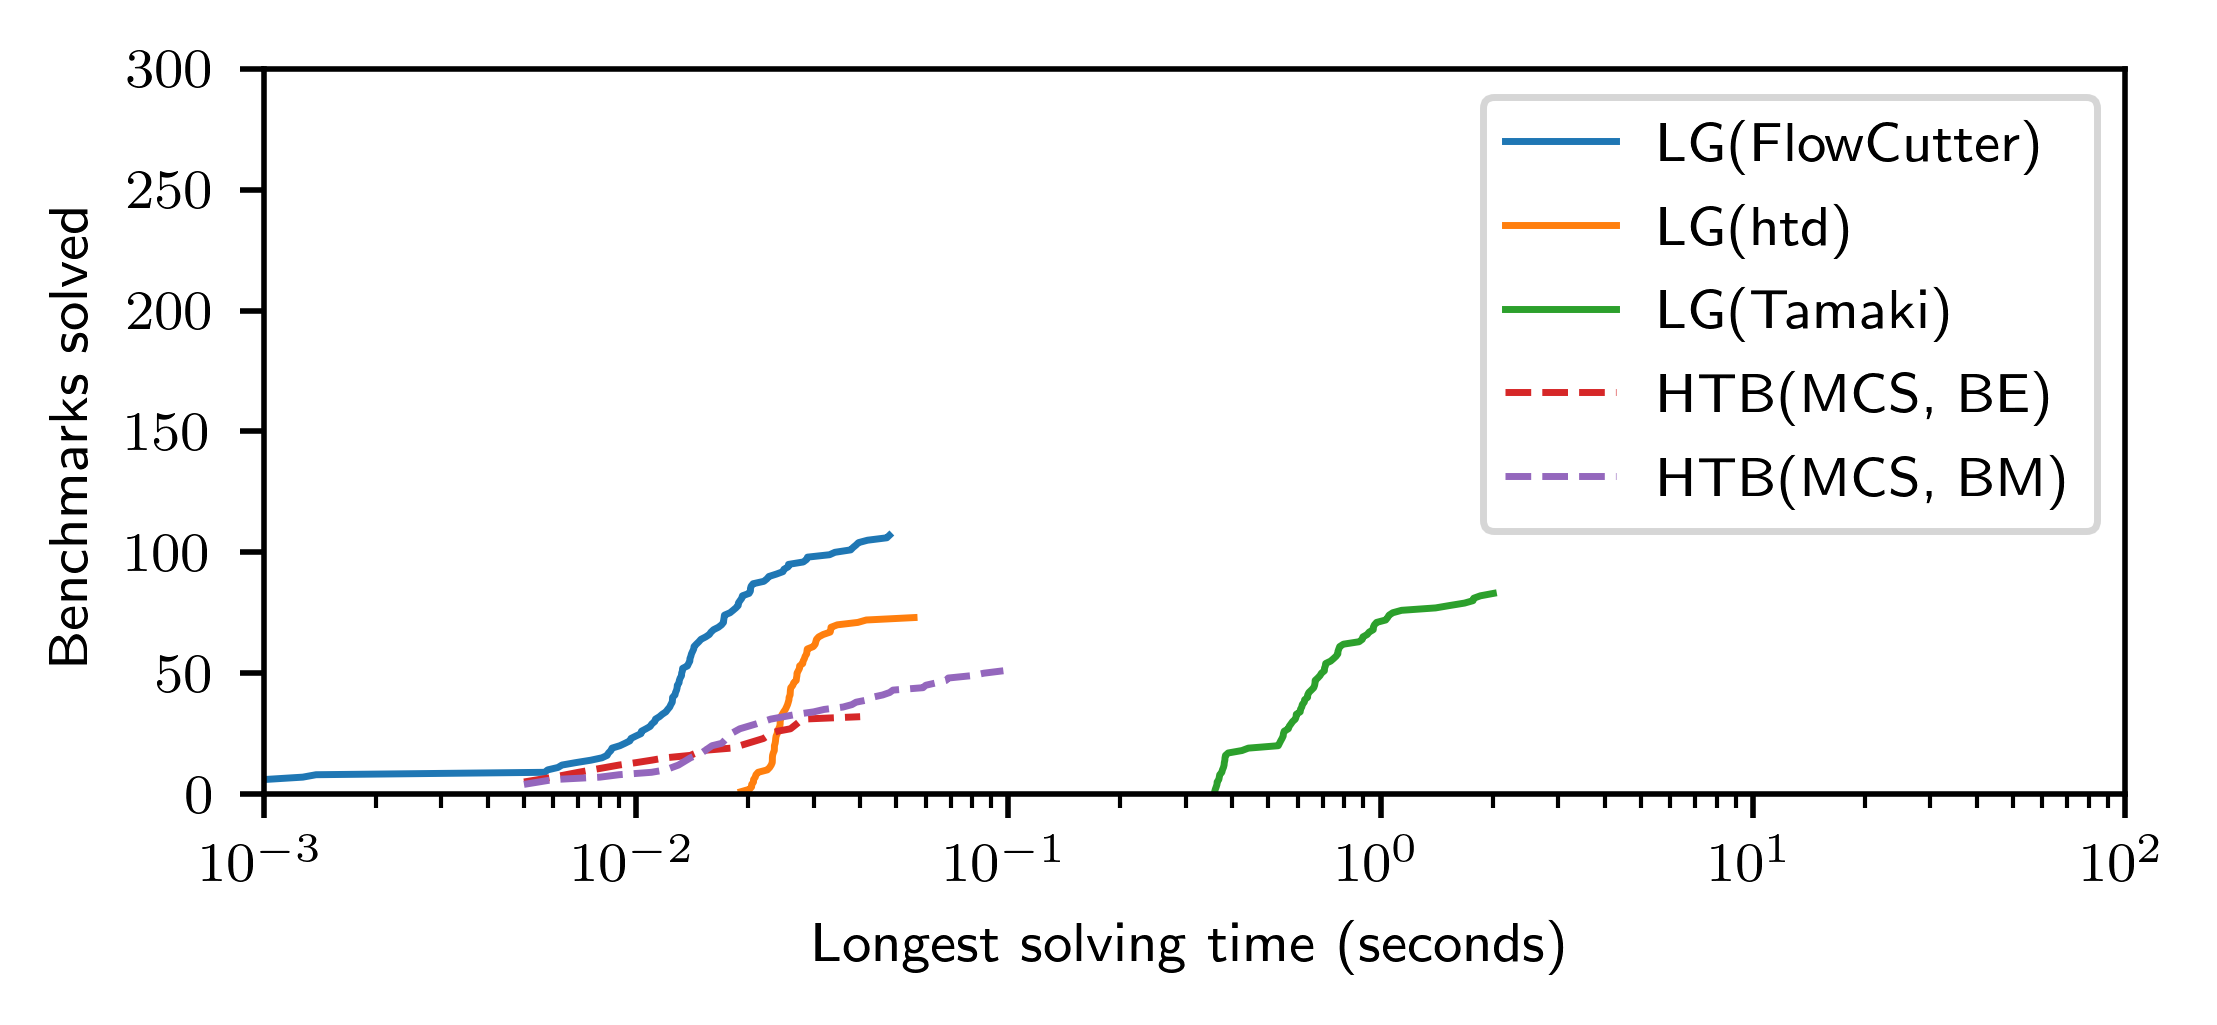

In [65]:
(fig, ax) = getFigAx(.4)

drawPlanningCurve(ax, getLgTimes(FLOW0), f'{LG}({FLOW})')
drawPlanningCurve(ax, getLgTimes(HTD0), f'{LG}({HTD})')
drawPlanningCurve(ax, getLgTimes(TCS0), f'{LG}({TCS})')
drawHtbCurves()

saveFig(fig, 'figPlanning.pgf')

In [66]:
def getLgTimeA(series):
    tree = 1
    while f'width{tree}' in series:
        if series[f'width{tree}'] <= MAX_WIDTH:
            return series[f'time{tree}']
        else:
            tree += 1

def getLgTimesA(exp): # returned a list which may contain None
    frame = exp.query('select * from data where time <= 100').merge(SATS)
    return [getLgTimeA(series) for (_, series) in frame.iterrows()]

def drawHtbCurvesA(ax):
    styles = {
        'MCS': '--',
        'LP': ':',
        'LM': '-.',
        'MF': '-',
    }
    for (cv, style) in styles.items():
        for rank in ['BE', 'BM']:
            for choice in ['Tree']:
                drawPlanningCurve(
                    ax,
                    getHtbTimes(cv, rank, choice),
                    f'HTB({cv}, {rank})',
                    style
                )

def drawCurves1A(heightByWidth):
    (fig, ax) = getFigAx(heightByWidth)
    ax.set_xlim(MIN_TIME, SECS1)
    ax.set_ylim(0, 120)
    drawCurve(ax, getLgTimesA(FLOW0), f'{LG}({FLOW})', '-')
    drawCurve(ax, getLgTimesA(HTD0), f'{LG}({HTD})', '-')
    drawCurve(ax, getLgTimesA(TCS0), f'{LG}({TCS})', '-')
    drawHtbCurvesA(ax)
    saveFig(fig, 'figPlanningA.pgf')

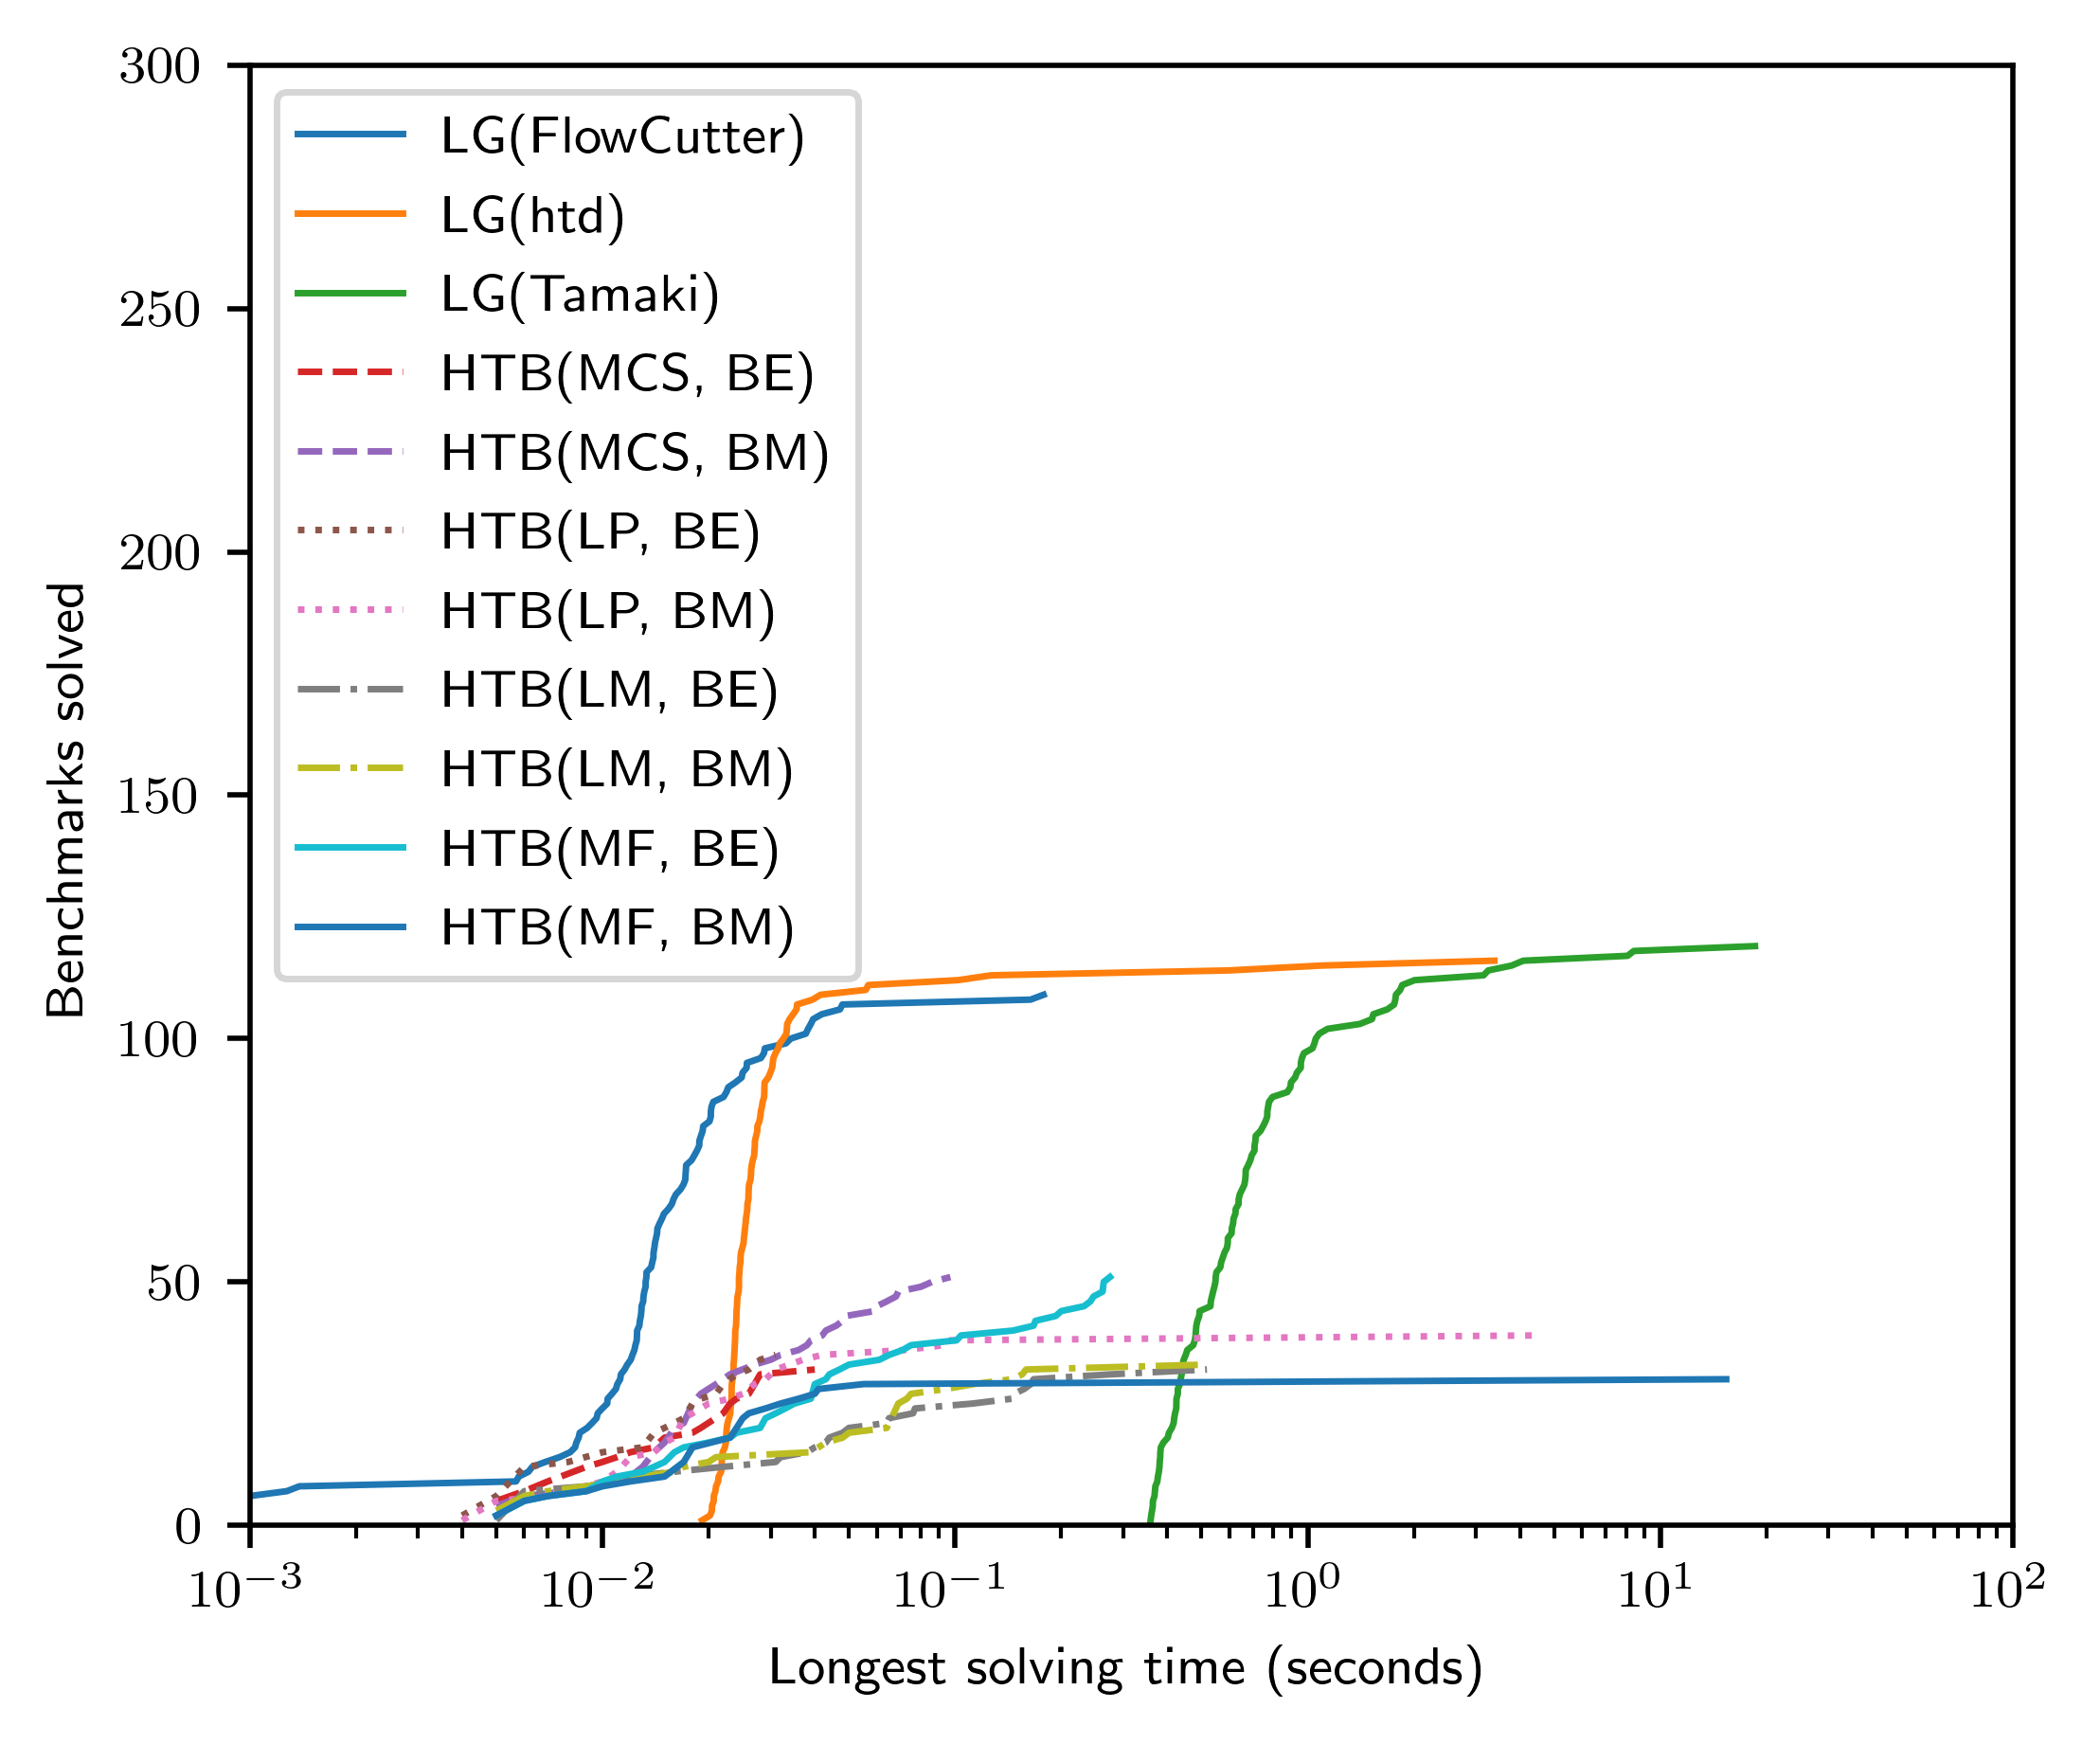

In [67]:
drawCurves1A(.85)

### Execution phase

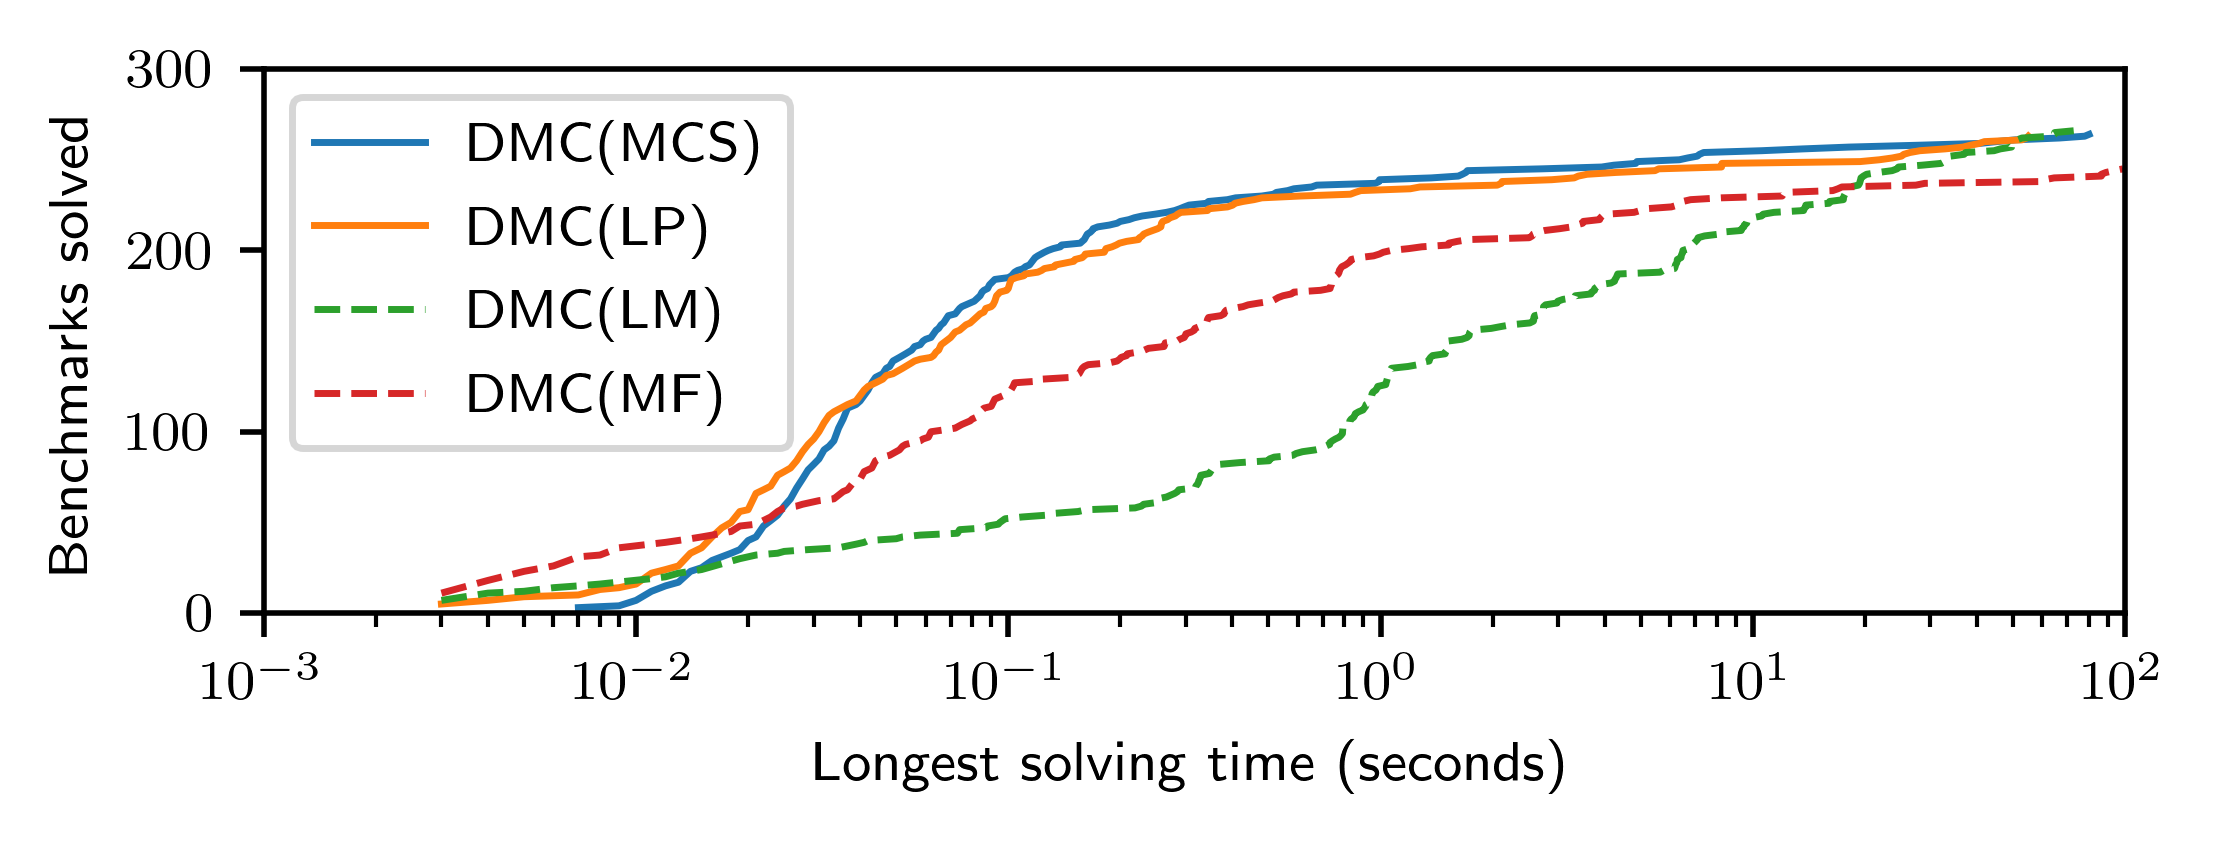

In [68]:
(fig, ax) = getFigAx(.3)

def getExecutionTimes(exp):
    return exp.query('''
        select * from data where time <= 100 and count > 0
    ''')[TIME].tolist()

def drawExecutionCurve(exp, name, style='-'):
    drawCurve(ax, getExecutionTimes(exp), name, style)
    ax.set_xlim(MIN_TIME, SECS2)
    ax.set_ylim(0, 300)

drawExecutionCurve(MCS_FLOW0, f'{DMC}(MCS)')
drawExecutionCurve(LP_FLOW0, f'{DMC}(LP)')
drawExecutionCurve(LM_FLOW0, f'{DMC}(LM)', '--')
drawExecutionCurve(MF_FLOW0, f'{DMC}(MF)', '--')

saveFig(fig, 'figExecution.pgf')

In [69]:
def drawExecutionCurveA(ax, exp, name, style):
    drawCurve(ax, getExecutionTimes(exp), name, style)

def drawFirstTreeCurveA(ax, exp, name, style='-'):
    drawExecutionCurveA(ax, exp, f'{name}, first', style)

def drawTimedTreesCurveA(ax, exp, name, style=':'):
    drawExecutionCurveA(ax, exp, f'{name}, last', style)

def drawExecutionCurvesA(heightByWidth):
    (fig, ax) = getFigAx(heightByWidth)
    ax.set_xlim(MIN_TIME, SECS2)
    ax.set_ylim(0, 300)

    drawFirstTreeCurveA(ax, MCS_FLOW0, f'{DMC}(MCS)') # top
#     drawFirstTreeCurveA(ax, IMCS_FLOW0, f'{DMC}(InvMCS)') # top
    drawFirstTreeCurveA(ax, LP_FLOW0, f'{DMC}(LP)') # top
#     drawFirstTreeCurveA(ax, ILP_FLOW0, f'{DMC}(InvLP)') # top
    drawFirstTreeCurveA(ax, LM_FLOW0, f'{DMC}(LM)', '--') # bottom
#     drawFirstTreeCurveA(ax, ILM_FLOW0, f'{DMC}(InvLM)') # bottom
    drawFirstTreeCurveA(ax, MF_FLOW0, f'{DMC}(MF)', '--') # middle
#     drawFirstTreeCurveA(ax, IMF_FLOW0, f'{DMC}(InvMF)') # middle
#     drawFirstTreeCurveA(ax, RAND_FLOW0, f'{DMC}(Rand)') # top

    drawTimedTreesCurveA(ax, MCS_T_FLOW0, f'{DMC}(MCS)') # top
    drawTimedTreesCurveA(ax, LP_T_FLOW0, f'{DMC}(LP)') # top
    drawTimedTreesCurveA(ax, LM_T_FLOW0, f'{DMC}(LM)', '-.') # bottom
    drawTimedTreesCurveA(ax, MF_T_FLOW0, f'{DMC}(MF)', '-.') # middle

    saveFig(fig, 'figExecutionA.pgf')

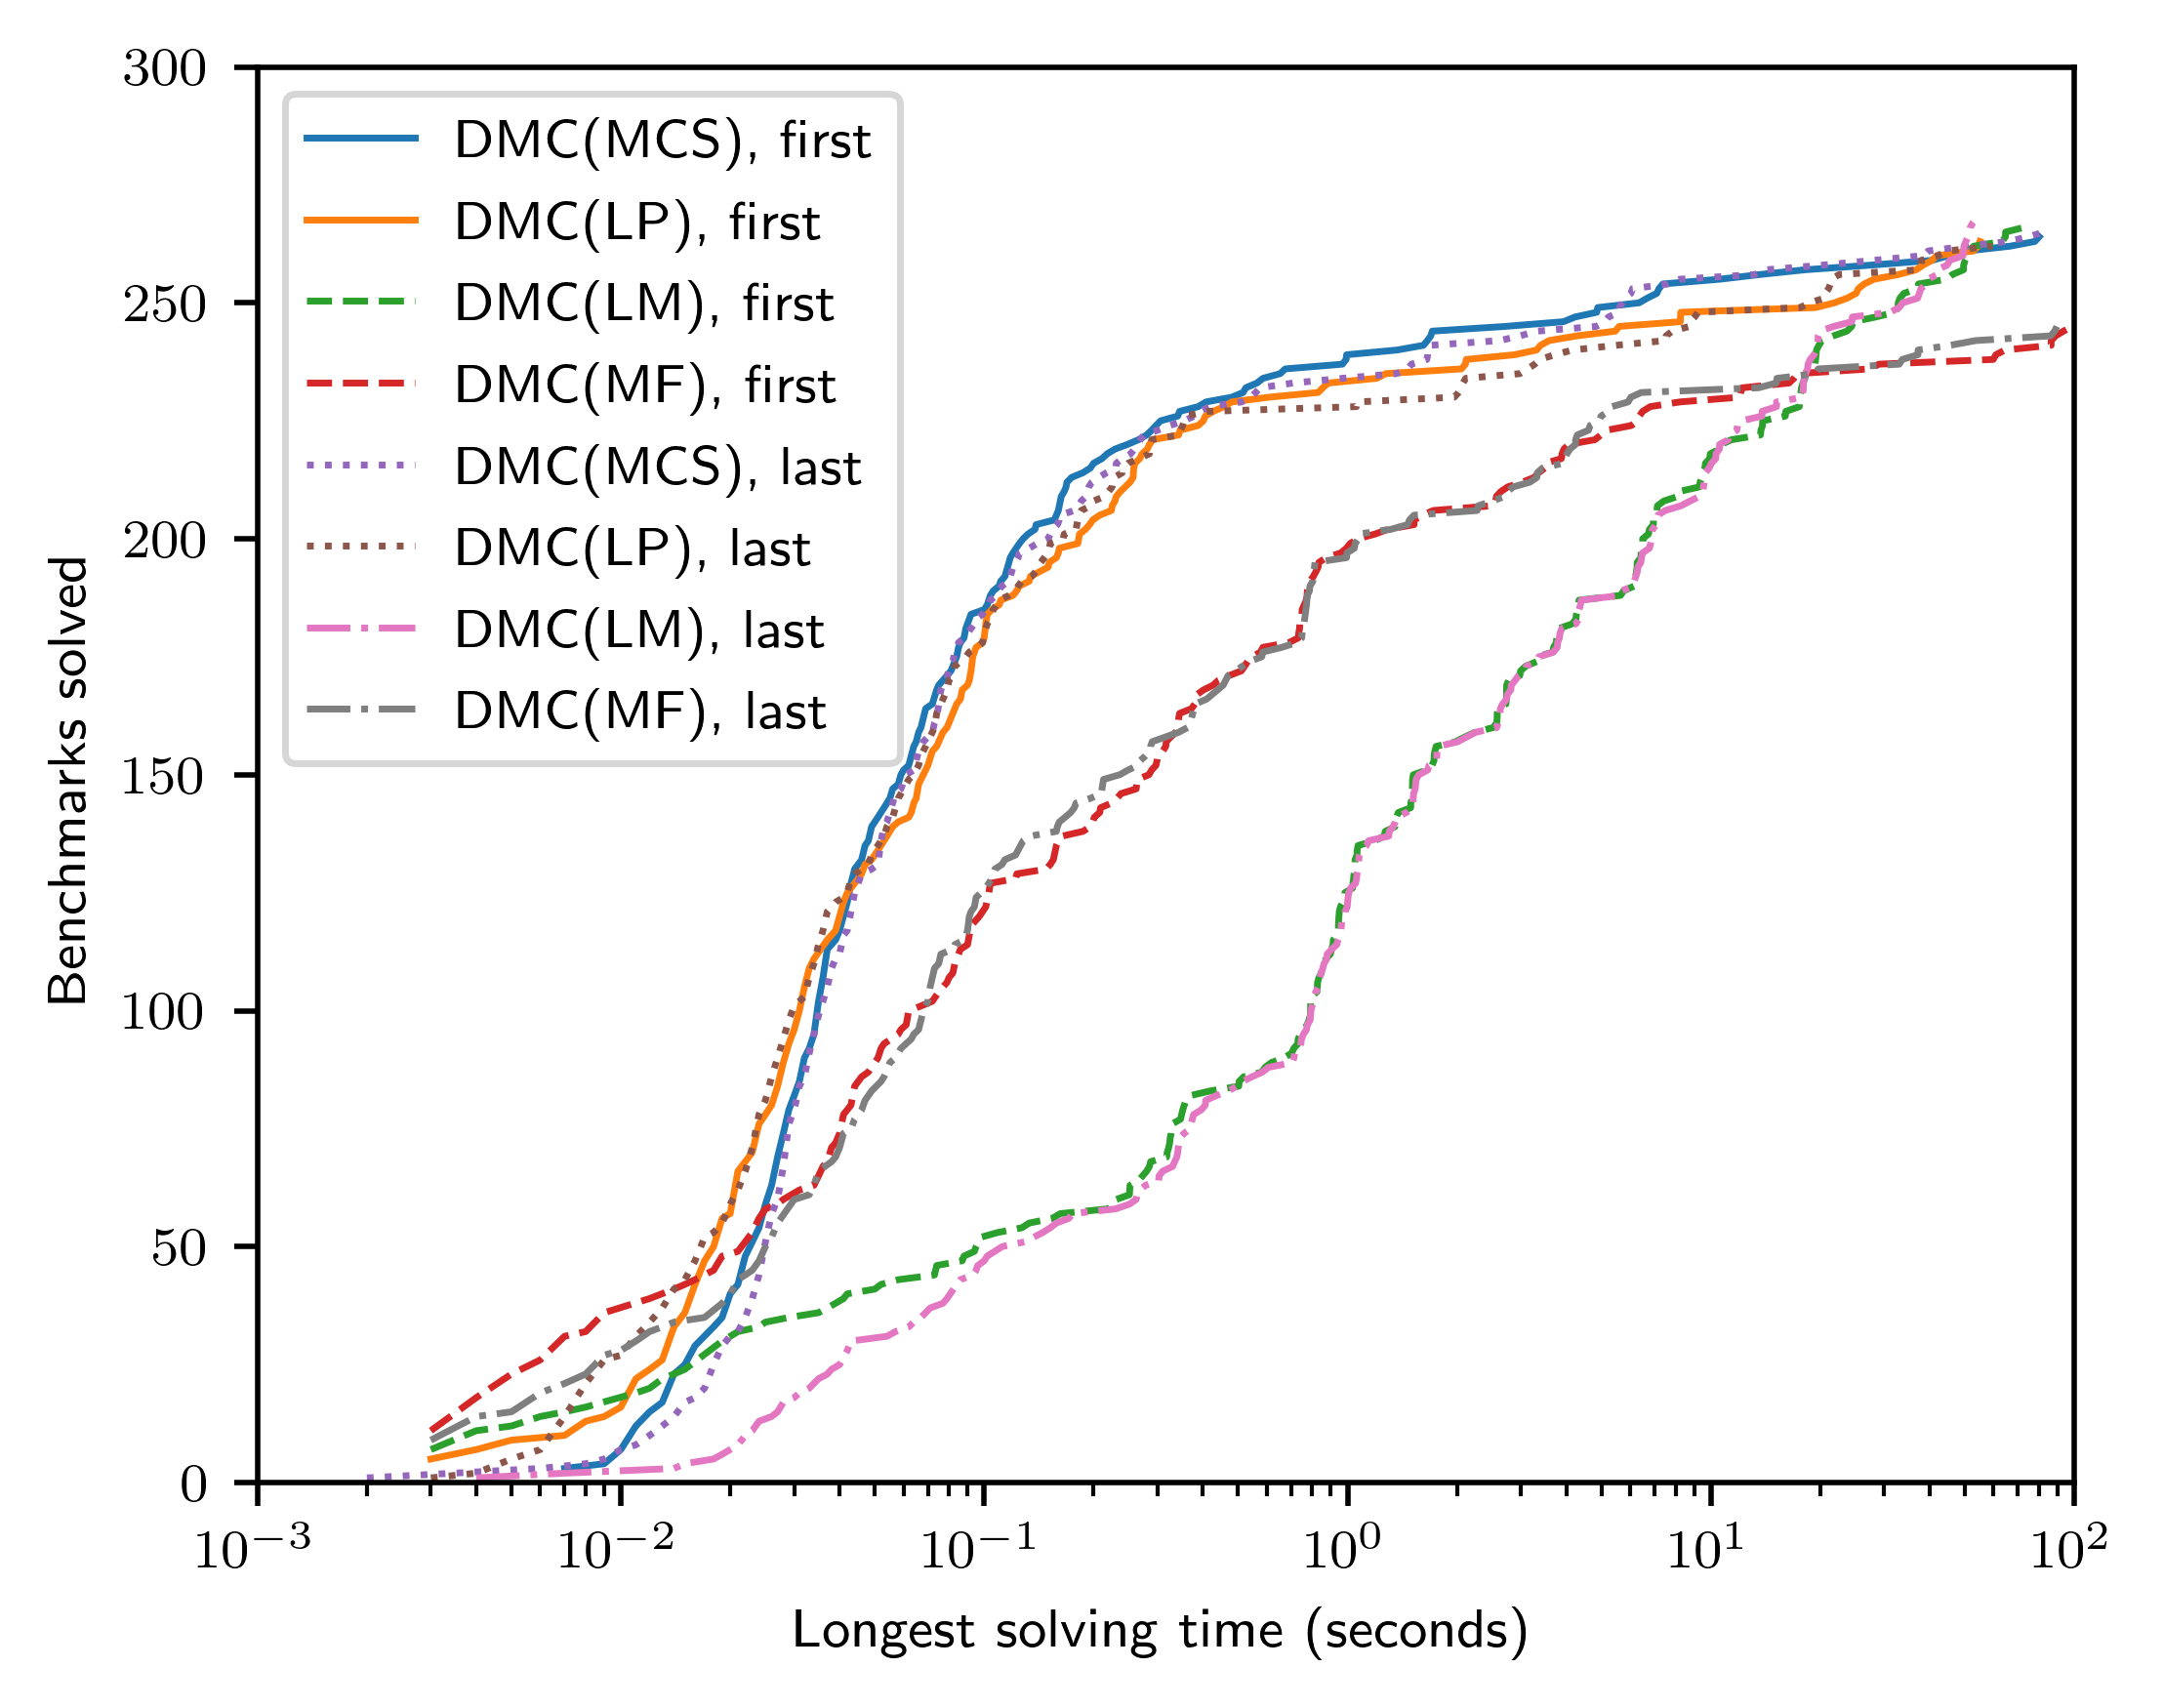

In [70]:
drawExecutionCurvesA(.8)

### Solving

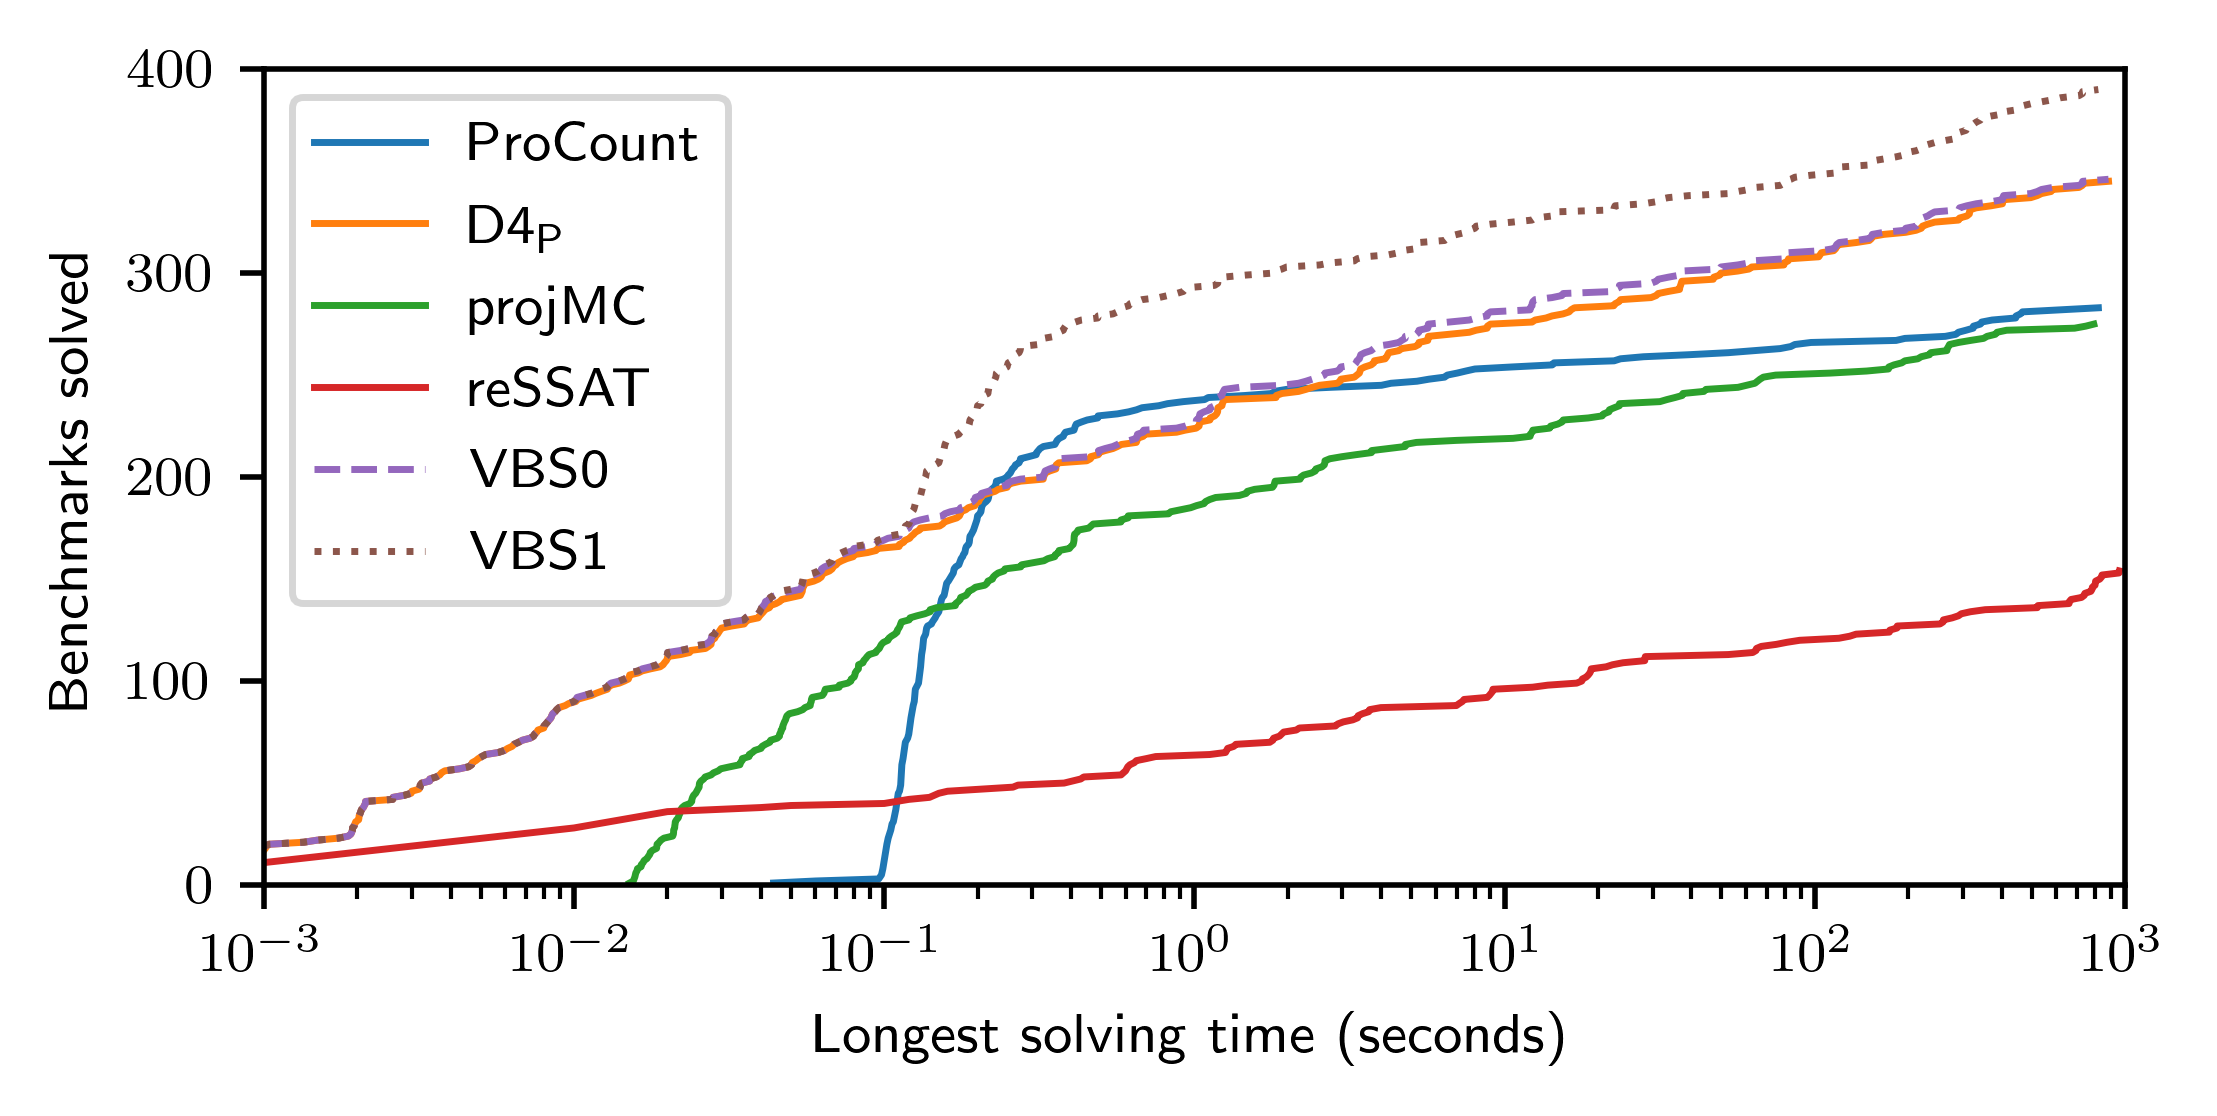

In [71]:
(fig, ax) = getFigAx(.45)

def getSolvingTimes(exp):
    return exp.query('''
        select * from data where time <= 1000 and count > 0
    ''')[TIME].tolist()

def drawSolvingCurve(exp, name):
    drawCurve(ax, getSolvingTimes(exp), name, '-', width=1)
    ax.set_xlim(MIN_TIME, SECS3)
    ax.set_ylim(0, 400)

drawSolvingCurve(FLOW_MCS0, DPMC)
drawSolvingCurve(D4P0, D4P)
drawSolvingCurve(PROJMC0, PROJMC)
drawSolvingCurve(SSAT0, SSAT)

def drawCurveVbs(solvers, name, style):
    drawCurve(ax, getVbsTimes(solvers), name, style)

drawCurveVbs(['D4p', 'Projmc', 'Ssat'], 'VBS0', '--')
drawCurveVbs(['Dpmc', 'D4p', 'Projmc', 'Ssat'], 'VBS1', ':')

saveFig(fig, 'figSolving.pgf')

In [72]:
def drawSolvingCurveA(ax, exp, name, style='-.'):
    drawCurve(ax, getSolvingTimes(exp), name, style)

def drawSolvingCurvesA(heightByWidth):
    (fig, ax) = getFigAx(heightByWidth)
    ax.set_xlim(MIN_TIME, SECS3)
    ax.set_ylim(0, 400)

    drawSolvingCurveA(ax, FLOW_MCS0, f'{DPMC}({FLOW}, MCS)', '-')
    drawSolvingCurveA(ax, FLOW_LP0, f'{DPMC}({FLOW}, LP)')

    drawSolvingCurveA(ax, HTD_MCS0, f'{DPMC}({HTD}, MCS)')
    drawSolvingCurveA(ax, HTD_LP0, f'{DPMC}({HTD}, LP)')

    drawSolvingCurveA(ax, TCS_MCS0, f'{DPMC}({TCS}, MCS)')
    drawSolvingCurveA(ax, TCS_LP0, f'{DPMC}({TCS}, LP)')

#     drawSolvingCurveA(D4P0, D4P)
#     drawSolvingCurveA(PROJMC0, PROJMC)
#     drawSolvingCurveA(SSAT0, SSAT)

    saveFig(fig, 'figSolvingA.pgf')

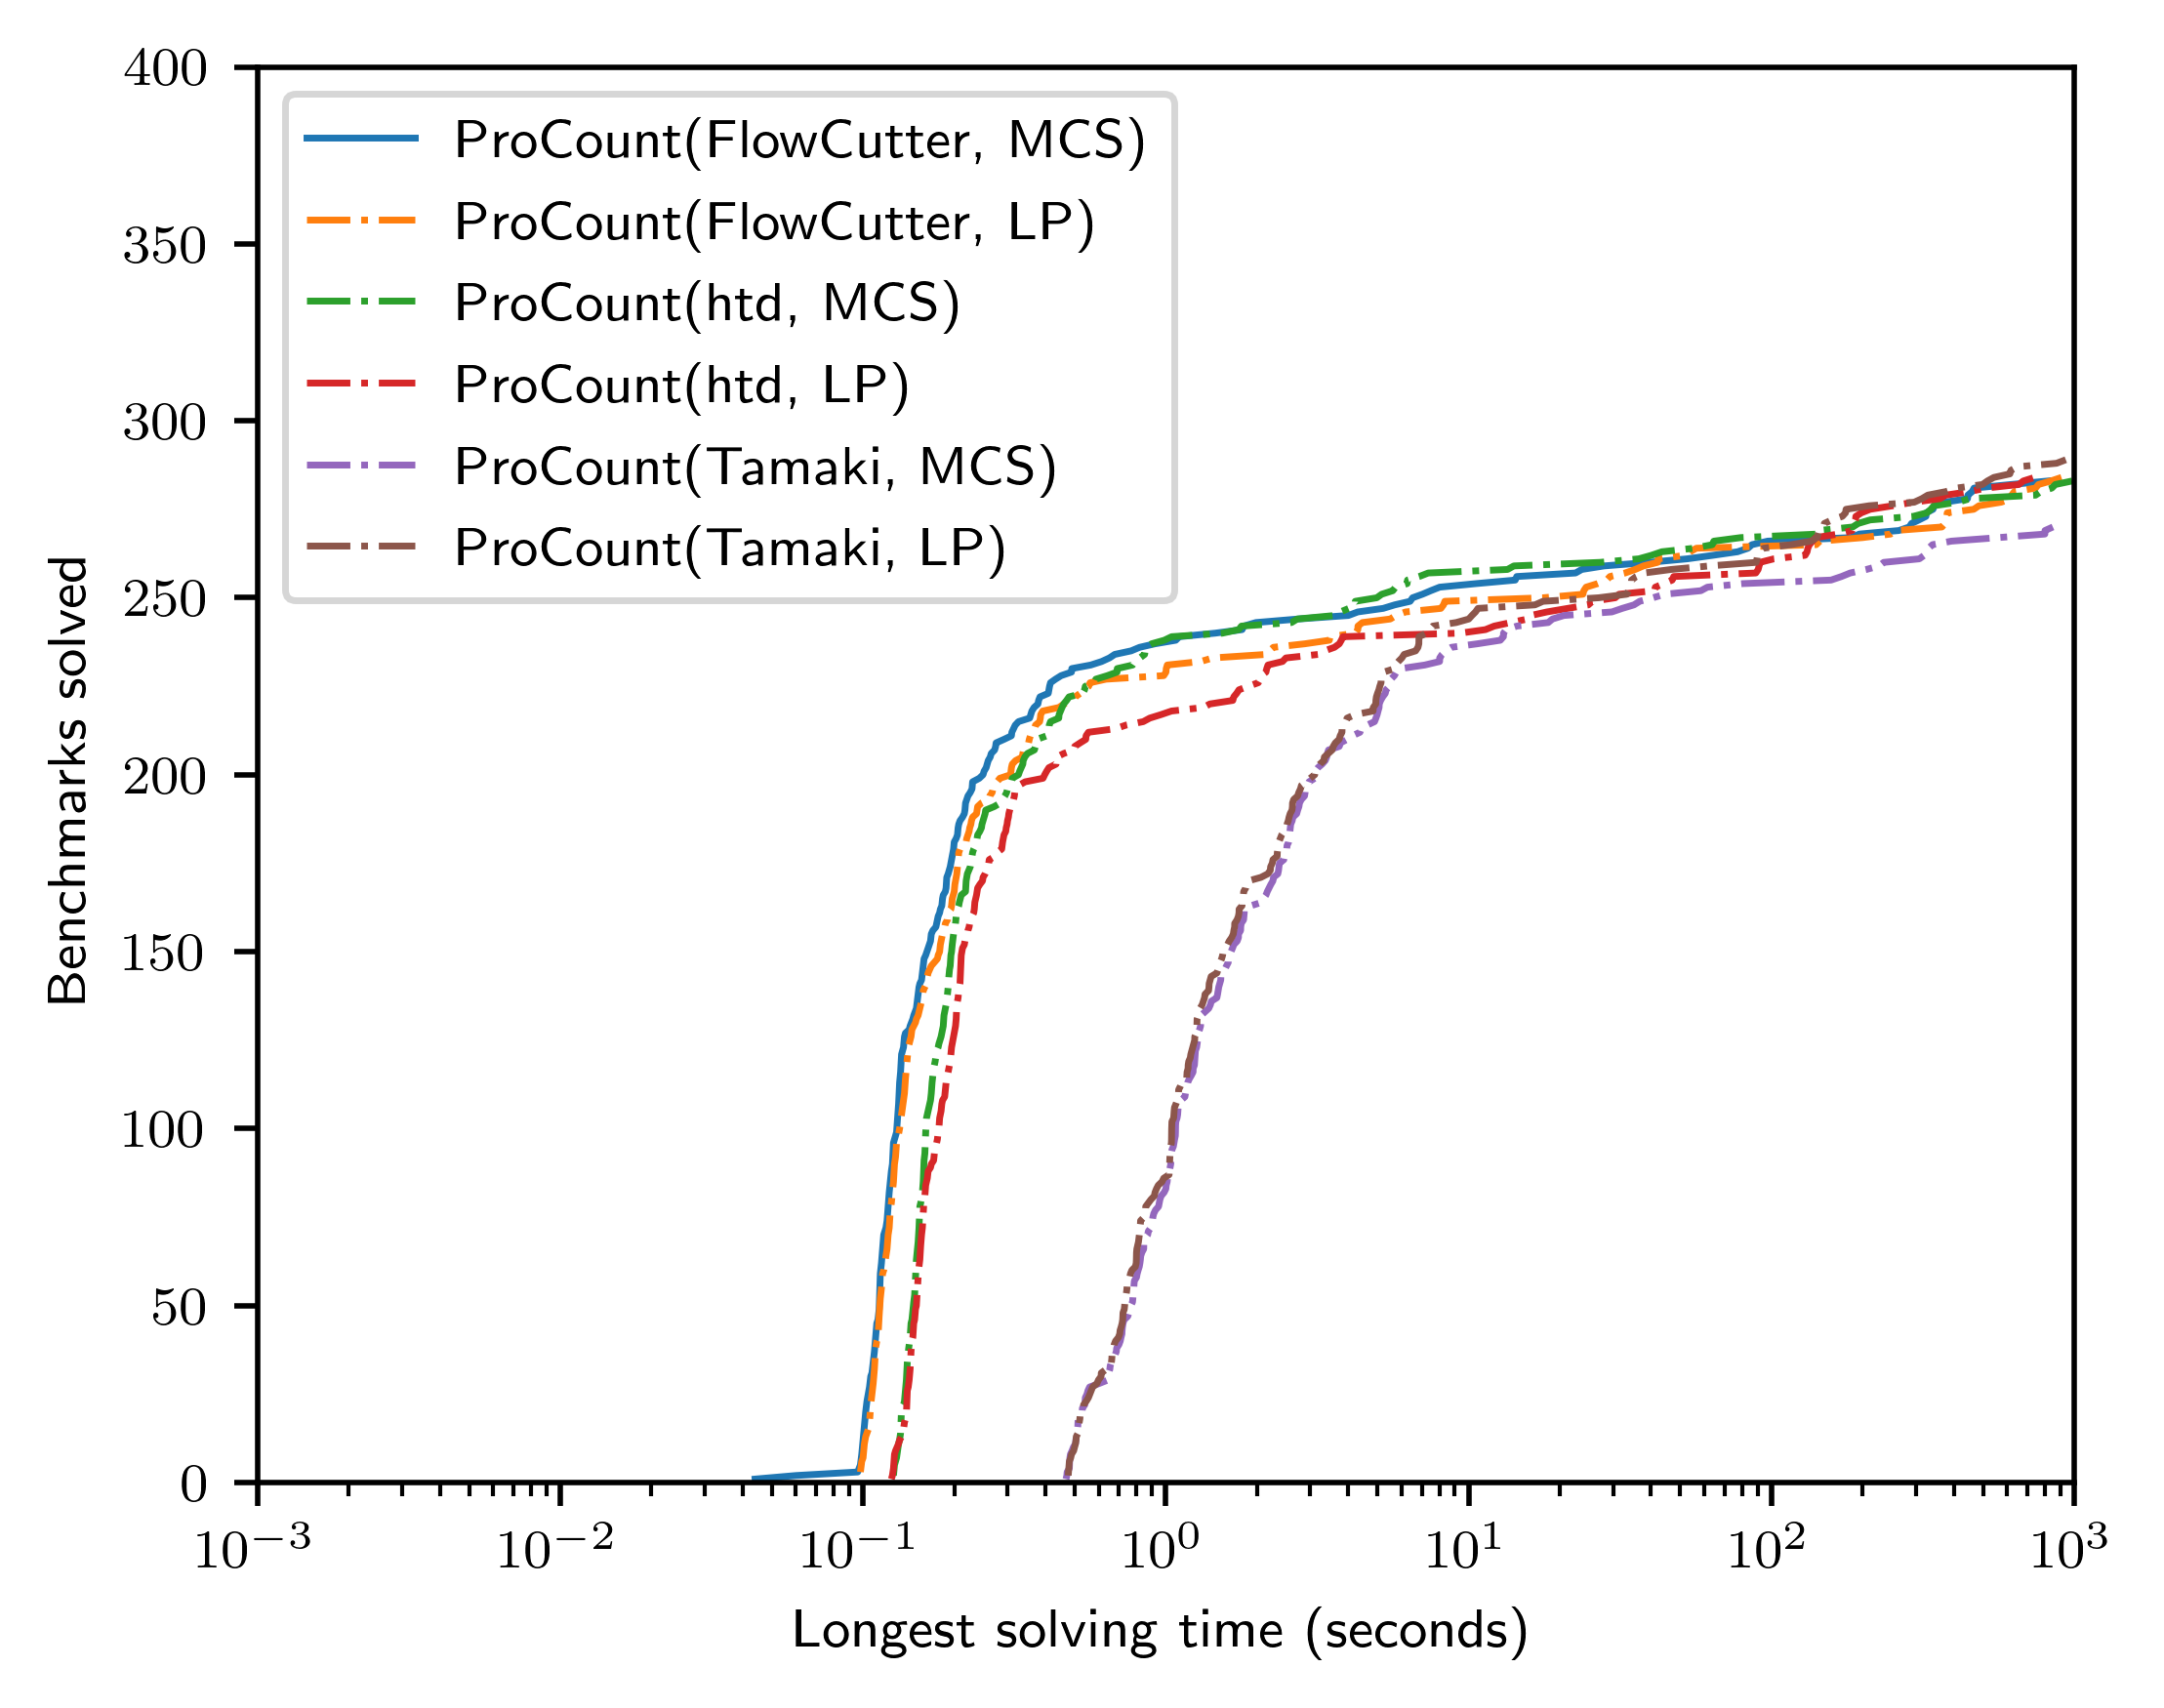

In [73]:
drawSolvingCurvesA(.8)

#### Solving time vs project-join tree width

In [74]:
WIDTH_TABLE = FLOW0.query(f'''
select benchmark,width1,time1 from data
where width is not null
order by width1
''')

WIDTH_TABLE = WIDTH_TABLE.merge(SAT_TABLE)

WIDTH_TABLE

,benchmark,width1,time1,countDpmc,timeDpmc,countD4p,timeD4p,countProjmc,timeProjmc,countSsat,timeSsat
0,tableBasedAddition.sk_240_1024.no_w,1.0,0.012892,NaN,NaN,0.000000,0.000995,0.000000,0.016252,0.000000,0.06
1,tutorial1.sk_1_1.no_w,1.0,0.000939,NaN,NaN,0.400000,0.000823,0.400000,0.015536,0.400000,0.00
2,blasted_case200.no_w,7.0,0.013251,0.071680,0.152,0.071680,0.000564,0.071680,0.024876,0.071680,0.00
3,blasted_case206.no_w,7.0,0.020626,0.126720,0.101,0.126720,0.000785,0.126720,0.015627,0.126720,0.00
4,s27_new_15_7.no_w,8.0,0.000786,0.256000,0.096,0.256000,0.001020,0.256000,0.016012,0.256000,0.00
...,...,...,...,...,...,...,...,...,...,...,...
341,70.sk_3_40.no_w,98.0,9.875650,NaN,NaN,0.002212,0.011382,0.002212,0.036668,0.002212,0.43
342,71.sk_3_65.no_w,98.0,21.191400,NaN,NaN,0.002675,0.875810,0.002675,35.400131,0.002675,724.01
343,blasted_case130.no_w,99.0,2.913290,0.000000,13.923,0.000000,451.434491,NaN,1122.260000,1.000000,1100.15
344,blasted_case_0_b14_1.no_w,99.0,0.101515,0.000004,6.407,NaN,1100.380000,NaN,1100.000000,1.000000,1100.12


In [75]:
import statistics

def getPar2ScoresByWidthBySolver(): # returns solver |-> (width |-> par-2 scores)
    mapping = collections.defaultdict(dict)
    for (_, row) in WIDTH_TABLE.iterrows():
        for solver in ['Dpmc', 'D4p', 'Projmc', 'Ssat']:
            t = row[f'time{solver}']
            if not (t <= SECS3 and row[f'count{solver}'] > 0):
                t = SECS3 * 2
            w = row['width1']
            if w not in mapping[solver]:
                mapping[solver][w] = []
#             t = max(t, MIN_TIME) # linear scale
            mapping[solver][w].append(t)
    return mapping

def getTimesByWidthBySolver(): # returns solver |-> (width |-> times)
    mapping = collections.defaultdict(dict)
    for (_, row) in WIDTH_TABLE.iterrows():
        for solver in ['Dpmc', 'D4p', 'Projmc', 'Ssat']:
            t = row[f'time{solver}']
            if t <= 1000 and row[f'count{solver}'] > 0:
                w = row['width1']
                if w not in mapping[solver]:
                    mapping[solver][w] = []
                t = max(t, MIN_TIME) # log scale
                mapping[solver][w].append(t)
    return mapping

def getMeanScoreByMeanWidthBySolver(
    widthCount,
    par2
): # returns solver |-> mean width |-> mean score
    assert widthCount > 0
    mapping = {}

    if par2:
        scoresByWidthBySolver = getPar2ScoresByWidthBySolver()
    else:
        scoresByWidthBySolver = getTimesByWidthBySolver()

    for (solver, scoresByWidth) in scoresByWidthBySolver.items():
        mapping[solver] = {} # mean width |-> mean score
        scoresByWidth = sorted(scoresByWidth.items())
        for i in range(len(scoresByWidth) - widthCount + 1):
            ws = []
            ts = []
            for (width, scores) in scoresByWidth[i : i + widthCount]:
                ws.append(width)
                ts.extend(scores)
            mapping[solver][statistics.mean(ws)] = statistics.mean(ts)
    return mapping

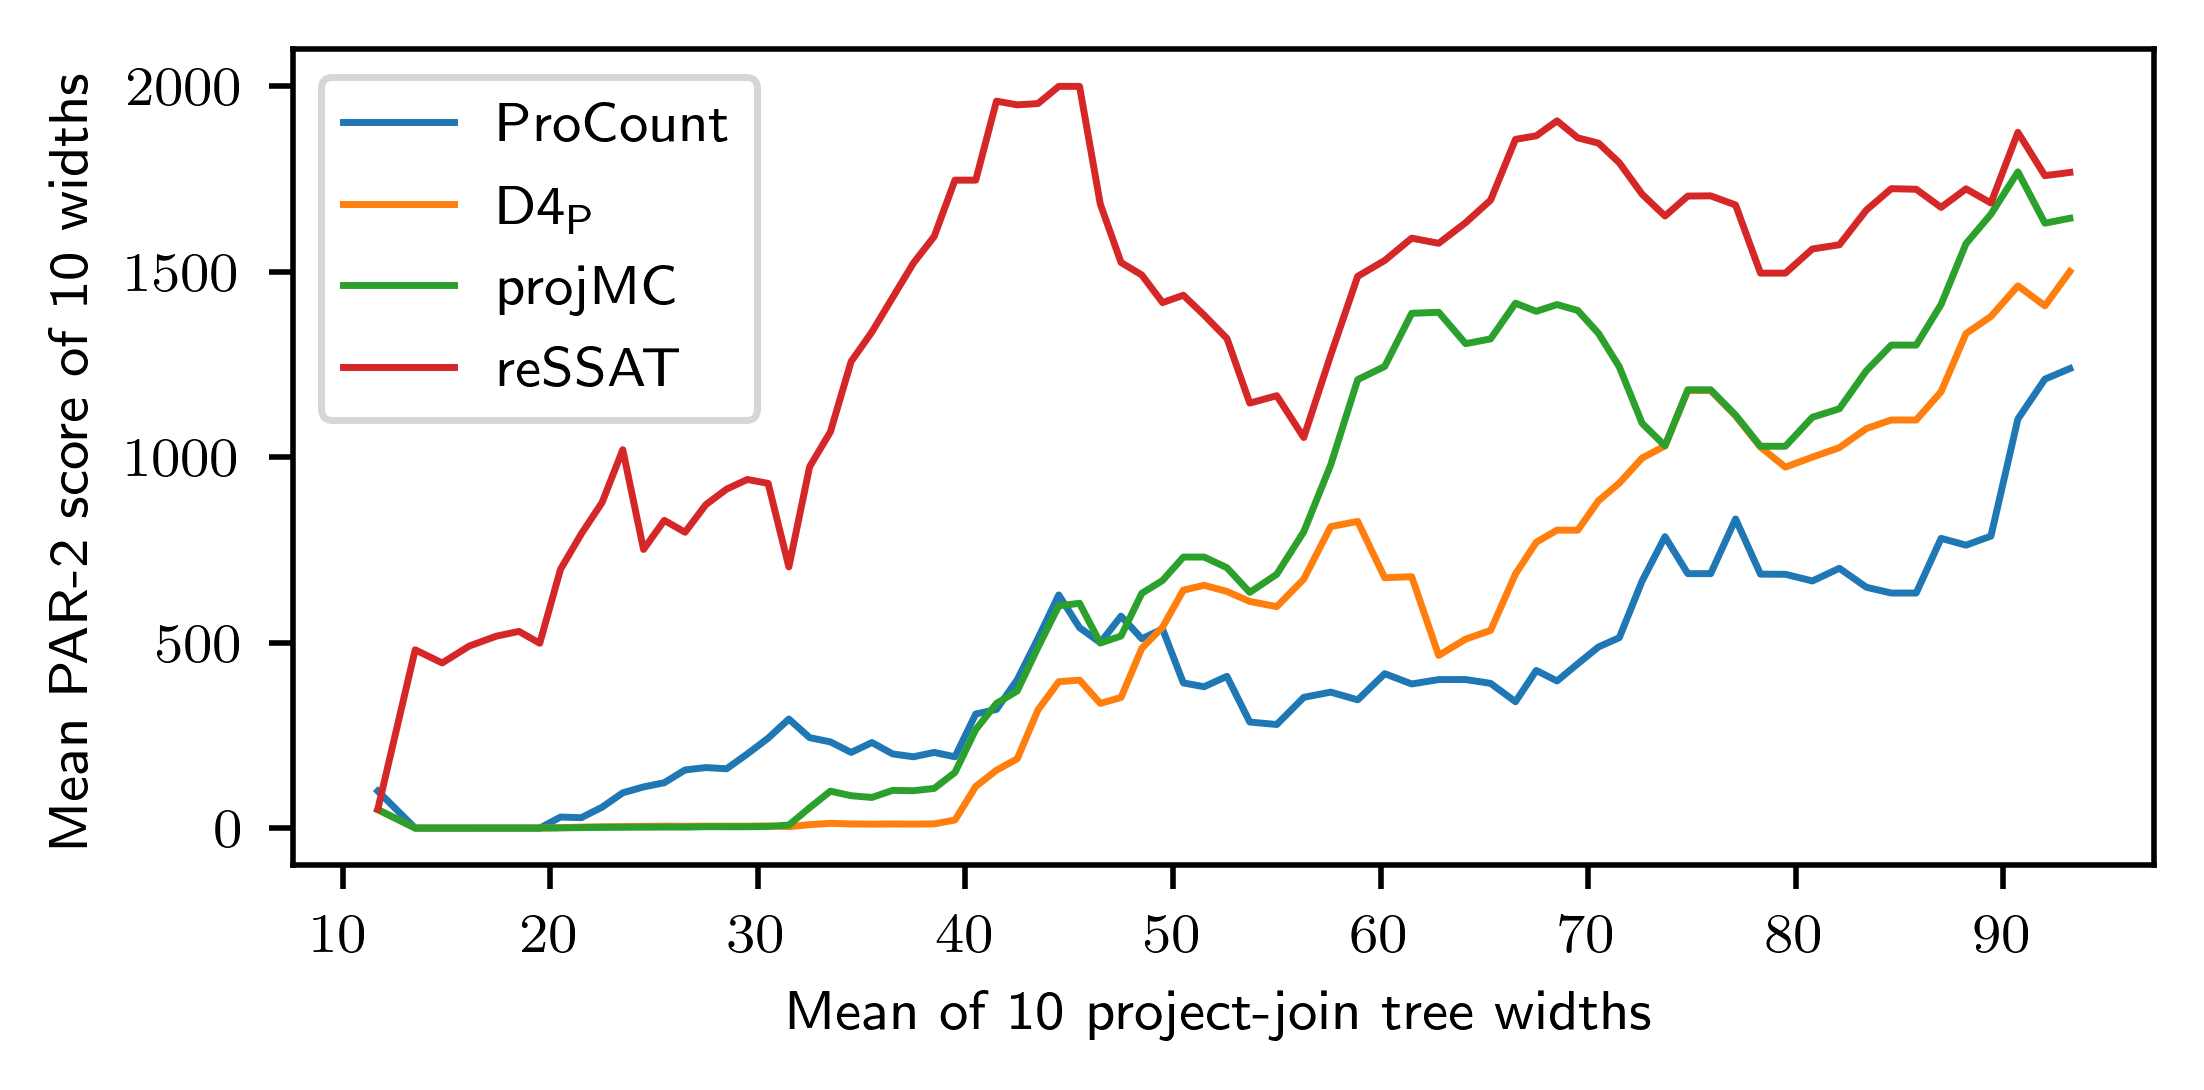

In [76]:
NAMES = {
    DPMC: 'Dpmc',
    D4P: 'D4p',
    PROJMC: 'Projmc',
    SSAT: 'Ssat'
}

def plotMeanPar2ScoreByMeanWidth():
    (fig, ax) = getFigAx(.45)
    widths = 10
    mapping = getMeanScoreByMeanWidthBySolver(widthCount=widths, par2=True)
    for (label, solver) in NAMES.items():
        m = mapping[solver]
        ax.plot(m.keys(), m.values(), label=label, linewidth=1)
    ax.legend()
#     ax.set_xlim(0, 100)
#     ax.set_yscale('log')
#     ax.set_ylim(MIN_TIME, SECS3 * 2)
#     ax.set_ylim(0, SECS3 * 2)
    ax.set_xlabel(f'Mean of {widths} project-join tree widths')
    ax.set_ylabel(f'Mean PAR-2 score of {widths} widths')
    saveFig(fig, 'figWidths.pgf')

plotMeanPar2ScoreByMeanWidth()

In [77]:
def plotMeanTimeByMeanWidth():
    (fig, ax) = getFigAx(.45)
    widths = 10
    mapping = getMeanScoreByMeanWidthBySolver(widthCount=widths, par2=False)
    for (label, solver) in NAMES.items():
        m = mapping[solver]
        ax.plot(m.keys(), m.values(), label=label, linewidth=1)
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlim(0, 100)
    ax.set_ylim(MIN_TIME, 1000)
    ax.set_xlabel(f'Mean of {widths} project-join tree widths')
    ax.set_ylabel(f'Mean solving time of {widths} widths')
    saveFig(fig, 'figWidths.pgf')

# plotMeanTimeByMeanWidth()